In [1]:
import pickle 
import glob
import os
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


In [2]:
PICKLE_DIR = "genomes_to_annotate_with_PlasmoFP/with_PFP_predictions_complete_2"
gene_dicts = {}
for pkl in glob.glob(f"{PICKLE_DIR}/*_gene_dict_with_PFP.pkl"):
    key = os.path.basename(pkl).split("_gene_dict")[0]
    with open(pkl, "rb") as f:
        gene_dicts[key] = pickle.load(f)

In [3]:
curated_keys = [
    ('GO Function', 'GO IEA Function'),
    ('GO Process',  'GO IEA Process'),
    ('GO Component','GO IEA Component'),
]

for curated, iea in curated_keys:
    term_info = defaultdict(lambda: {'curated': set(), 'iea': set()})
    
    for species, genes in gene_dicts.items():
        for gene_ann in genes.values():
            for term in gene_ann.get(curated, []):
                term_info[term]['curated'].add(species)
            for term in gene_ann.get(iea, []):
                term_info[term]['iea'].add(species)
    

In [21]:
curated_pairs = [
    ('GO Function', 'GO IEA Function'),
    ('GO Process',  'GO IEA Process'),
    ('GO Component','GO IEA Component'),
]

for curated, iea in curated_pairs:
    term_to_species = defaultdict(set)

    for species, genes in gene_dicts.items():
        for gene_ann in genes.values():
            for term in gene_ann.get(curated, []) + gene_ann.get(iea, []):
                term_to_species[term].add(species)

    onto = curated.split()[-1]  # "Function", "Process", or "Component"
    with open(f"GO_{onto}_all_species.tsv", 'w') as out:
        out.write("GO_ID\tSpecies_List\n")
        for term, sp_set in sorted(term_to_species.items()):
            species_list = ";".join(sorted(sp_set))
            out.write(f"{term}\t{species_list}\n")

pfp_keys = {
    'MF': 'PFP MF',
    'BP': 'PFP BP',
    'CC': 'PFP CC',
}

for short, slot in pfp_keys.items():
    term_thresh_to_species = defaultdict(lambda: defaultdict(set))

    for species, genes in gene_dicts.items():
        for gene_ann in genes.values():
            for thresh, go_tuples in gene_ann.get(slot, {}).items():
                for go_id, score, name in go_tuples:
                    term_thresh_to_species[(go_id, name)][thresh].add(species)

    # # write TSV
    # with open(f"PFP_{short}_all_species.tsv", 'w') as out:
    #     out.write("GO_ID\tTerm_Name\tThreshold\tSpecies_List\n")
    #     for (go_id, name), thresh_map in sorted(term_thresh_to_species.items()):
    #         for thresh, sp_set in sorted(thresh_map.items()):
    #             species_list = ";".join(sorted(sp_set))
    #             out.write(f"{go_id}\t{name}\t{thresh}\t{species_list}\n")


In [7]:
curated_slots = [
    'GO Function', 'GO IEA Function',
    'GO Process',  'GO IEA Process',
    'GO Component','GO IEA Component',
]

curated_terms = set()
for species_dict in gene_dicts.values():
    for ann in species_dict.values():
        for slot in curated_slots:
            for go_id in ann.get(slot, []):
                curated_terms.add(go_id)


pfp_slots = ['PFP MF','PFP BP','PFP CC']
pfp_terms_to_name = {}
for species_dict in gene_dicts.values():
    for ann in species_dict.values():
        for slot in pfp_slots:
            for thresh, gos in ann.get(slot, {}).items():
                for go_id, score, name in gos:
                    pfp_terms_to_name[go_id] = name


existing = sorted(curated_terms)
new_only = sorted(go for go in pfp_terms_to_name if go not in curated_terms)


# --- 4) Write out
with open('existing_terms_NEW_2.txt','w') as f:
    for go in existing:
        f.write(f"{go}\n")

with open('new_pfp_terms_NEW_2.txt', 'w') as f:
    for go in new_only:
        f.write(f"{go}\n")

with open('combined_existing_pfp_NEW_2.txt', 'w') as f:
    for go in existing + new_only:
        f.write(f"{go}\n")

print(f"Wrote {len(existing)} existing terms and {len(new_only)} new PFP-only terms and {len(existing) + len(new_only)} total to files.")


Wrote 3523 existing terms and 757 new PFP-only terms and 4280 total to files.


Now for Resnik Clustering 

see @calculate_resnik_similarity.py

# Get just the PUFs 

In [4]:
mf_clusters = pd.read_csv('resnik clustering/MF_term_clustersAUG23.tsv', sep='\t')
bp_clusters = pd.read_csv('resnik clustering/BP_term_clustersAUG23.tsv', sep='\t')
cc_clusters = pd.read_csv('resnik clustering/CC_term_clustersAUG23.tsv', sep='\t')

In [5]:
curated_slots = [
    'GO Function', 'GO IEA Function',
    'GO Process',  'GO IEA Process',
    'GO Component','GO IEA Component',
]

pfp_slots = ['PFP MF', 'PFP BP', 'PFP CC']

puf_genes = {}

for species, genes in gene_dicts.items():
    puf_list = []
    for gene_id, ann in genes.items():
        if any(ann.get(slot) for slot in curated_slots):
            continue
        
        if not any(
            any(go_set) 
            for slot in pfp_slots 
            for go_set in ann.get(slot, {}).values()
        ):
            continue
        
        puf_list.append(gene_id)
    
    puf_genes[species] = puf_list

for species, genes in puf_genes.items():
    print(f"{species}: {len(genes)} PUFs with PFP predictions")


PlasmoDB-68_PinuiSanAntonio1: 2244 PUFs with PFP predictions
PlasmoDB-68_PovalewallikeriPowCR01: 1551 PUFs with PFP predictions
PlasmoDB-68_PreichenowiCDC: 996 PUFs with PFP predictions
PlasmoDB-68_Pfalciparum3D7: 676 PUFs with PFP predictions
PlasmoDB-68_Pchabaudichabaudi: 1099 PUFs with PFP predictions
PlasmoDB-68_PfragileNilgiri: 1916 PUFs with PFP predictions
PlasmoDB-68_PblacklockiG01: 1314 PUFs with PFP predictions
PlasmoDB-68_PvivaxSal1: 1359 PUFs with PFP predictions
PlasmoDB-68_PcynomolgiM: 2243 PUFs with PFP predictions
PlasmoDB-68_PgaboniG01: 1402 PUFs with PFP predictions
PlasmoDB-68_Pyoeliiyoelii17XNL2023: 1713 PUFs with PFP predictions
PlasmoDB-68_PovalecurtisiGH01: 1721 PUFs with PFP predictions
PlasmoDB-68_PmalariaeUG01: 1187 PUFs with PFP predictions
PlasmoDB-68_PbergheiANKA: 1026 PUFs with PFP predictions
PlasmoDB-68_Pgallinaceum8A: 1136 PUFs with PFP predictions
PlasmoDB-68_PcoatneyiHackeri: 1751 PUFs with PFP predictions
PlasmoDB-68_PknowlesiH: 1093 PUFs with PFP pr

In [6]:
species_to_name = {'PlasmoDB-68_PadleriG01': 'P. adleri',
             'PlasmoDB-68_PbergheiANKA': 'P. berghei',
             'PlasmoDB-68_PblacklockiG01': 'P. blacklocki',
             'PlasmoDB-68_Pchabaudichabaudi': 'P. chabaudi',
             'PlasmoDB-68_PcoatneyiHackeri': 'P. coatneyi',
             'PlasmoDB-68_PcynomolgiM': 'P. cynomolgi',
             'PlasmoDB-68_Pfalciparum3D7': 'P. falciparum',
             'PlasmoDB-68_PfragileNilgiri': 'P. fragile',
             'PlasmoDB-68_PgaboniG01': 'P. gaboni',
             'PlasmoDB-68_Pgallinaceum8A': 'P. gallinaceum',
             'PlasmoDB-68_PinuiSanAntonio1': 'P. inui',
             'PlasmoDB-68_PknowlesiH': 'P. knowlesi',
             'PlasmoDB-68_PmalariaeUG01': 'P. malariae',
             'PlasmoDB-68_PovalecurtisiGH01': 'P. ovale curtisi',
             'PlasmoDB-68_PovalewallikeriPowCR01': 'P. ovale wallikeri',
             'PlasmoDB-68_PreichenowiCDC': 'P. reichenowi',
             'PlasmoDB-68_PvinckeibrucechwattiDA': 'P. vinckei',
             'PlasmoDB-68_PvivaxP01': 'P. vivax P01',
             'PlasmoDB-68_PvivaxSal1': 'P. vivax',
             'PlasmoDB-68_Pyoeliiyoelii17XNL2023': 'P. yoelii'}

In [7]:
cluster_dfs = {
    'MF': mf_clusters,  
    'BP': bp_clusters,
    'CC': cc_clusters
}

go_to_cluster = {
    onto: dict(zip(df['GO_ID'], df['ClusterName']))
    for onto, df in cluster_dfs.items()
}

curated_slots = {
    'MF': ('GO Function',      'GO IEA Function'),
    'BP': ('GO Process',       'GO IEA Process'),
    'CC': ('GO Component',     'GO IEA Component'),
}

all_counts_curated = {}
for onto, df_clusters in cluster_dfs.items():
    lookup = go_to_cluster[onto]
    cur1, cur2 = curated_slots[onto]
    species_counts = {}
    
    for species, genes in gene_dicts.items():
        c = Counter()
        for gid, ann in genes.items():
            go_ids = set(ann.get(cur1, []) + ann.get(cur2, []))
            # map GO IDs → cluster names, discard missing
            clusters = {lookup.get(go) for go in go_ids}
            clusters.discard(None)
            for cl in clusters:
                c[cl] += 1
        species_counts[species] = c
    
    df_counts = pd.DataFrame(species_counts).T.fillna(0).astype(int)
    df_counts = df_counts.reindex(sorted(df_counts.columns), axis=1)
    df_counts.to_csv(f'clustering_results/curated_iea_{onto}.tsv', sep='\t')
    all_counts_curated[onto] = df_counts


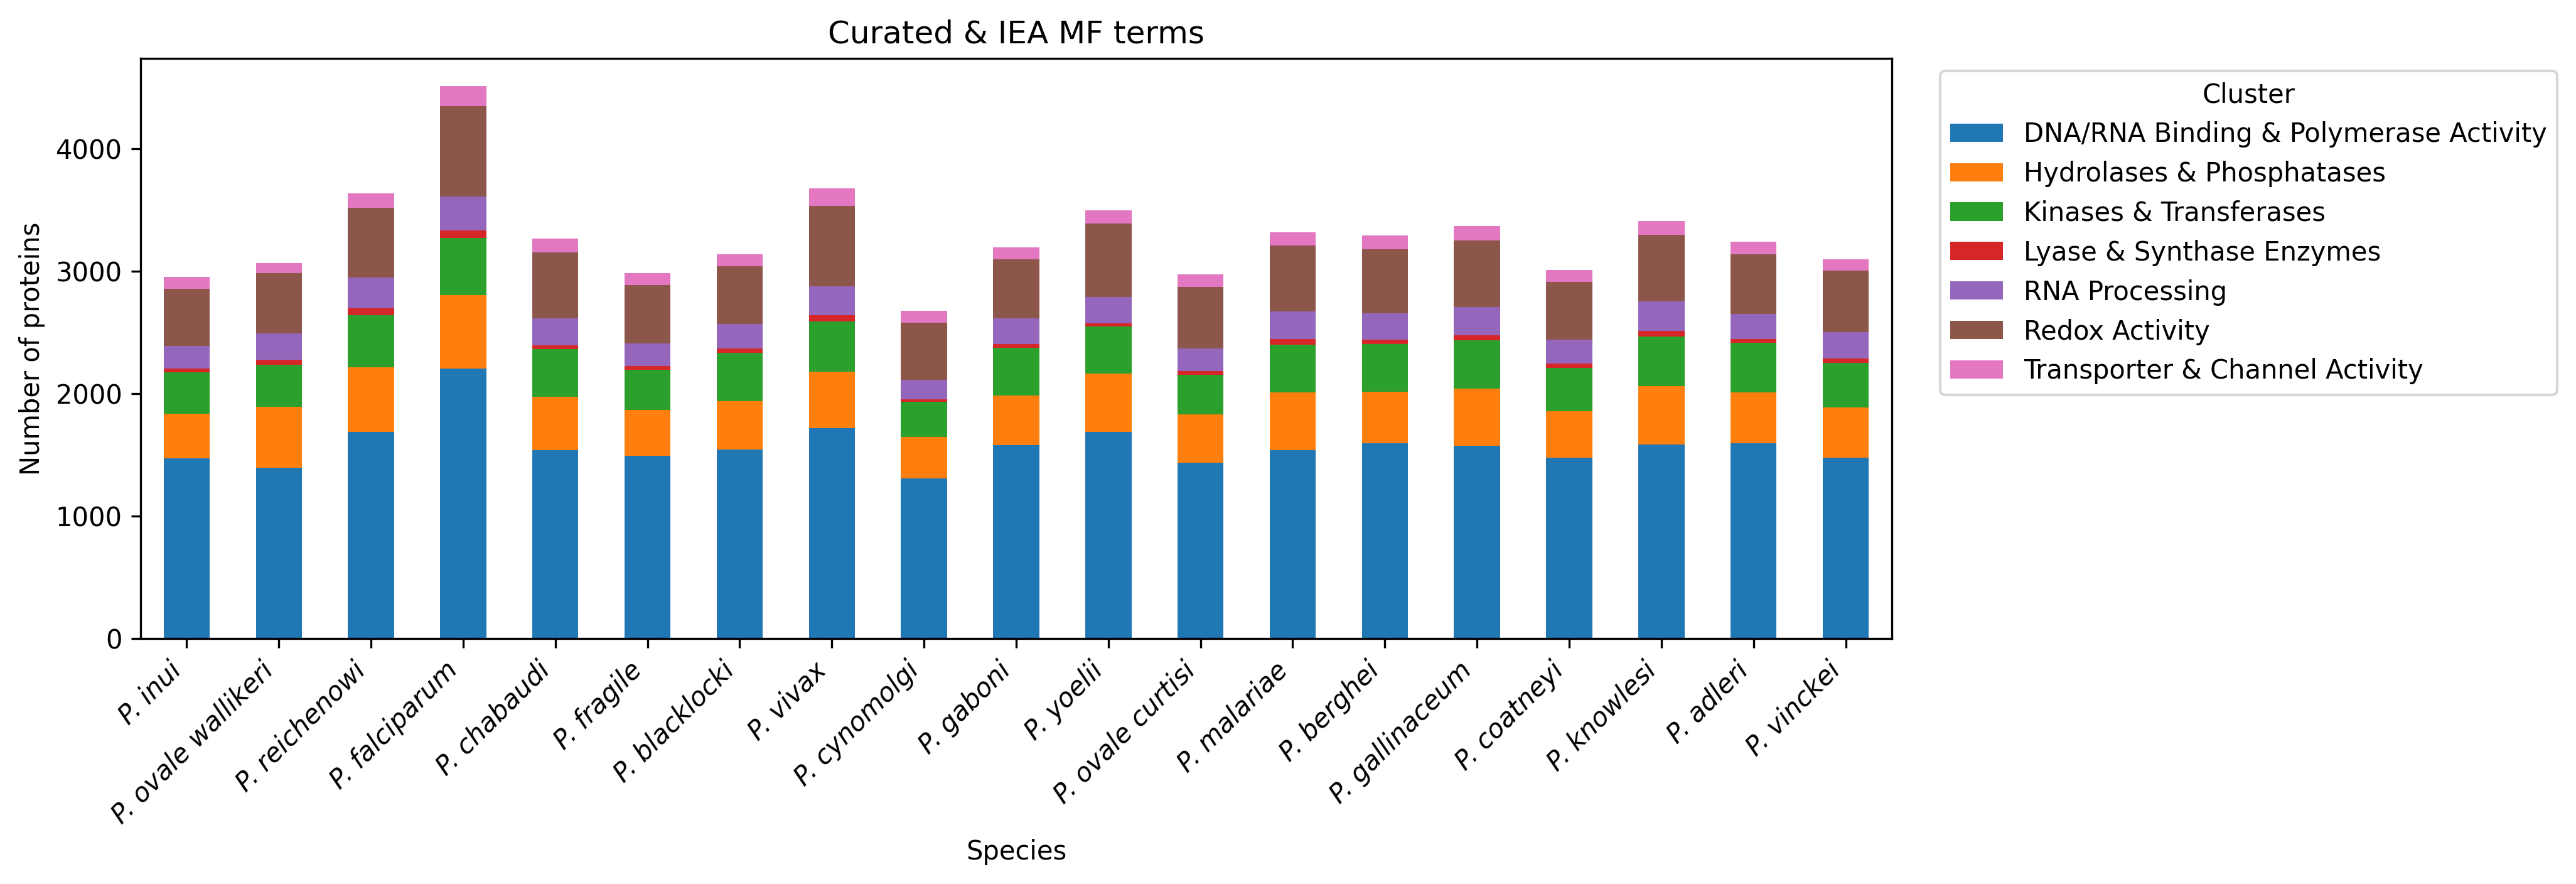

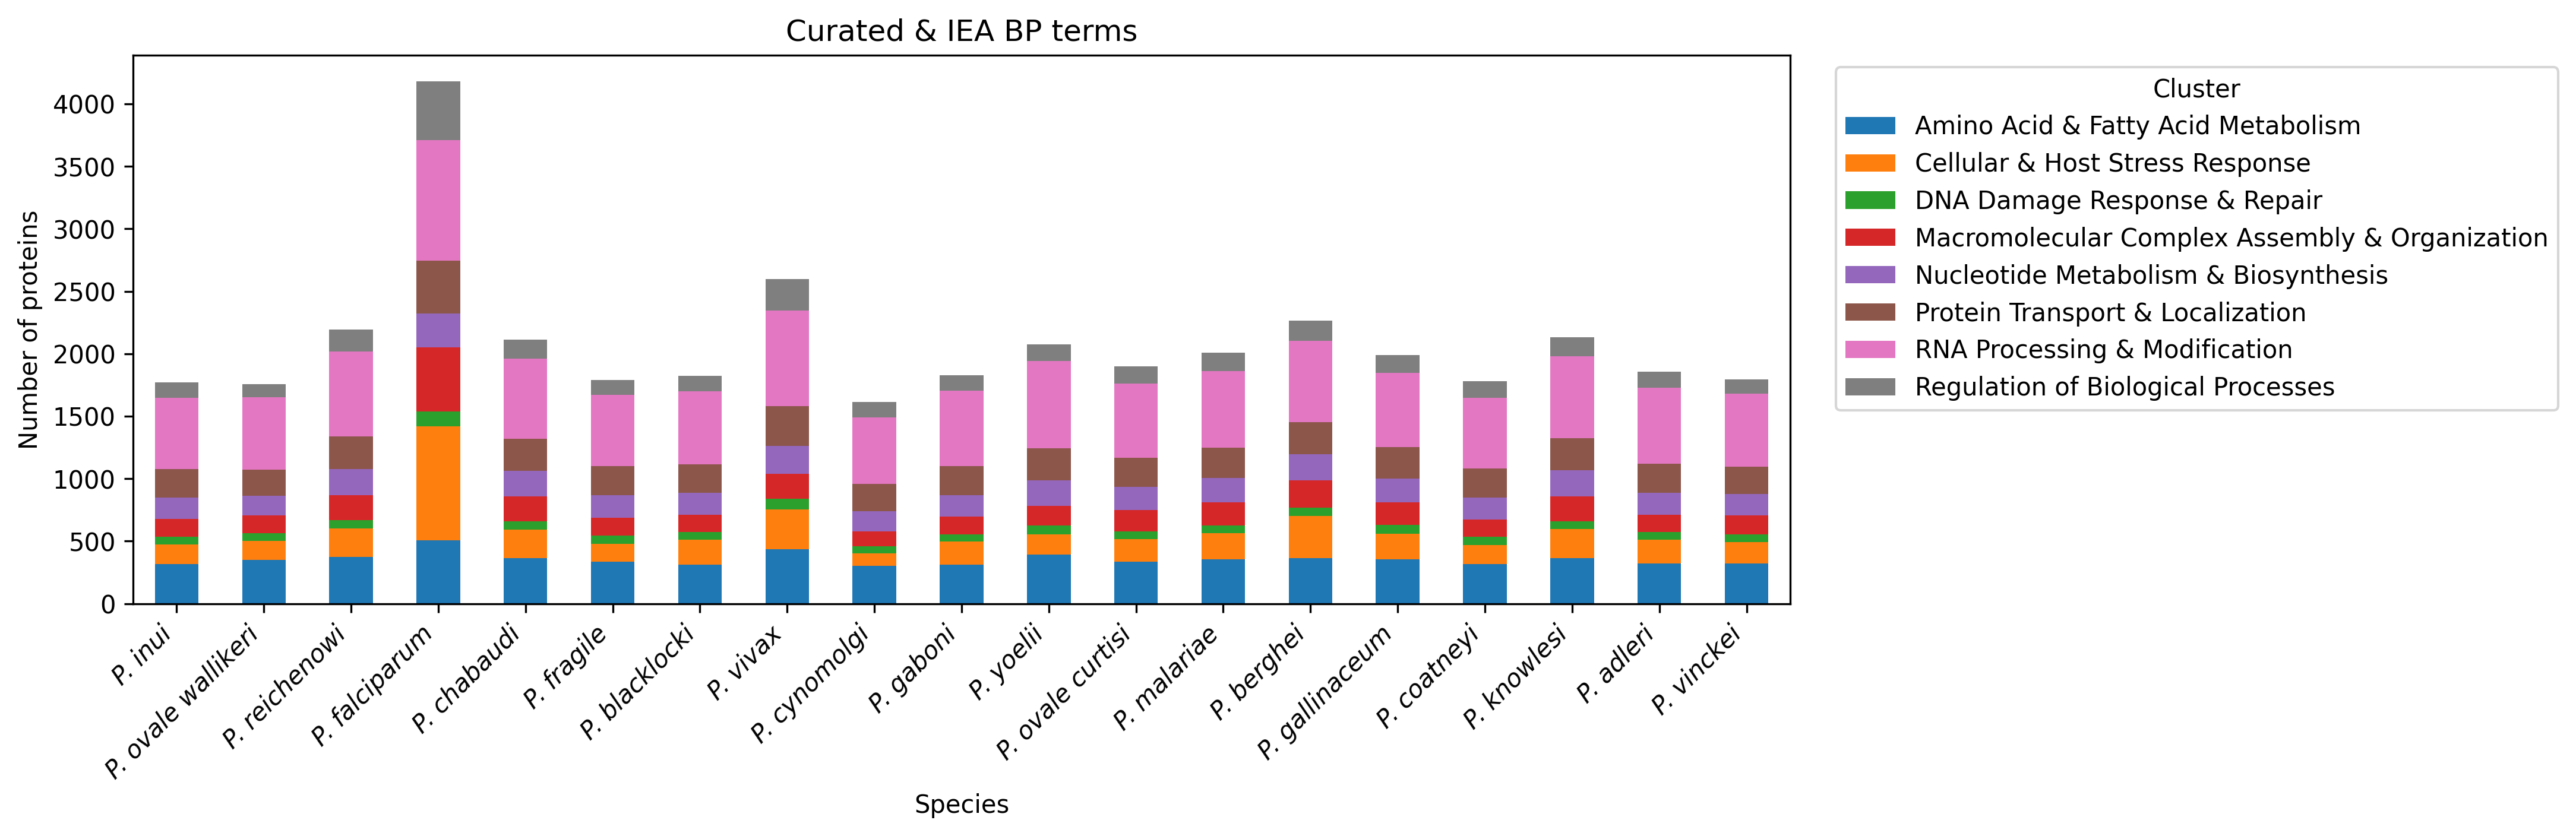

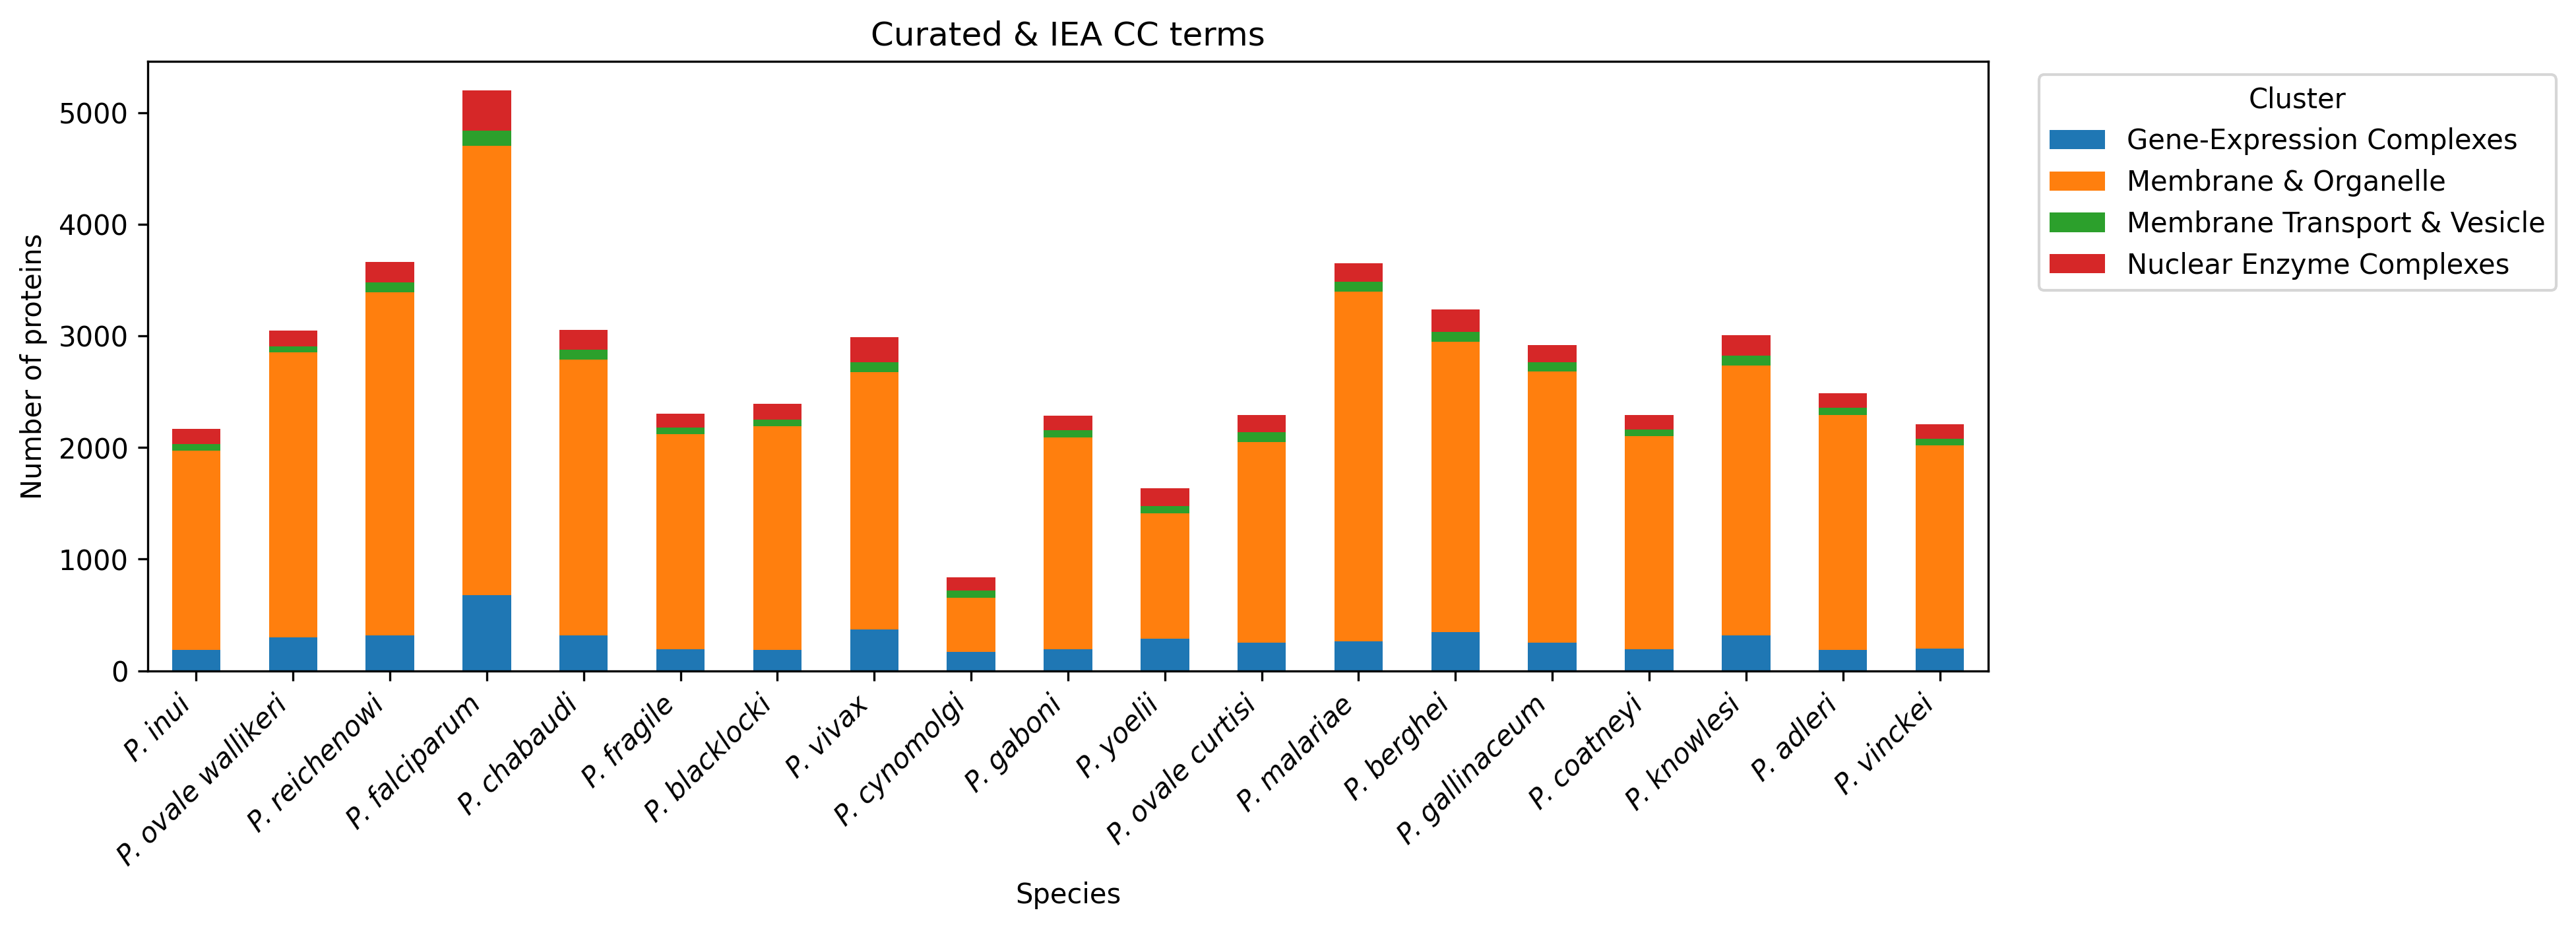

In [8]:
for onto, df_counts in all_counts_curated.items():
    fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
    
    df_counts.plot(
        kind='bar',
        stacked=True,
        ax=ax
    )
    
    ax.set_title(f"Curated & IEA {onto} terms")
    ax.set_xlabel("Species")
    ax.set_ylabel("Number of proteins")
    
    xticks = ax.get_xticks()
    friendly = [species_to_name.get(code, code) for code in df_counts.index]
    ax.set_xticks(xticks)
    ax.set_xticklabels(friendly, rotation=45, ha='right', fontstyle='italic')
    
    ax.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.show()

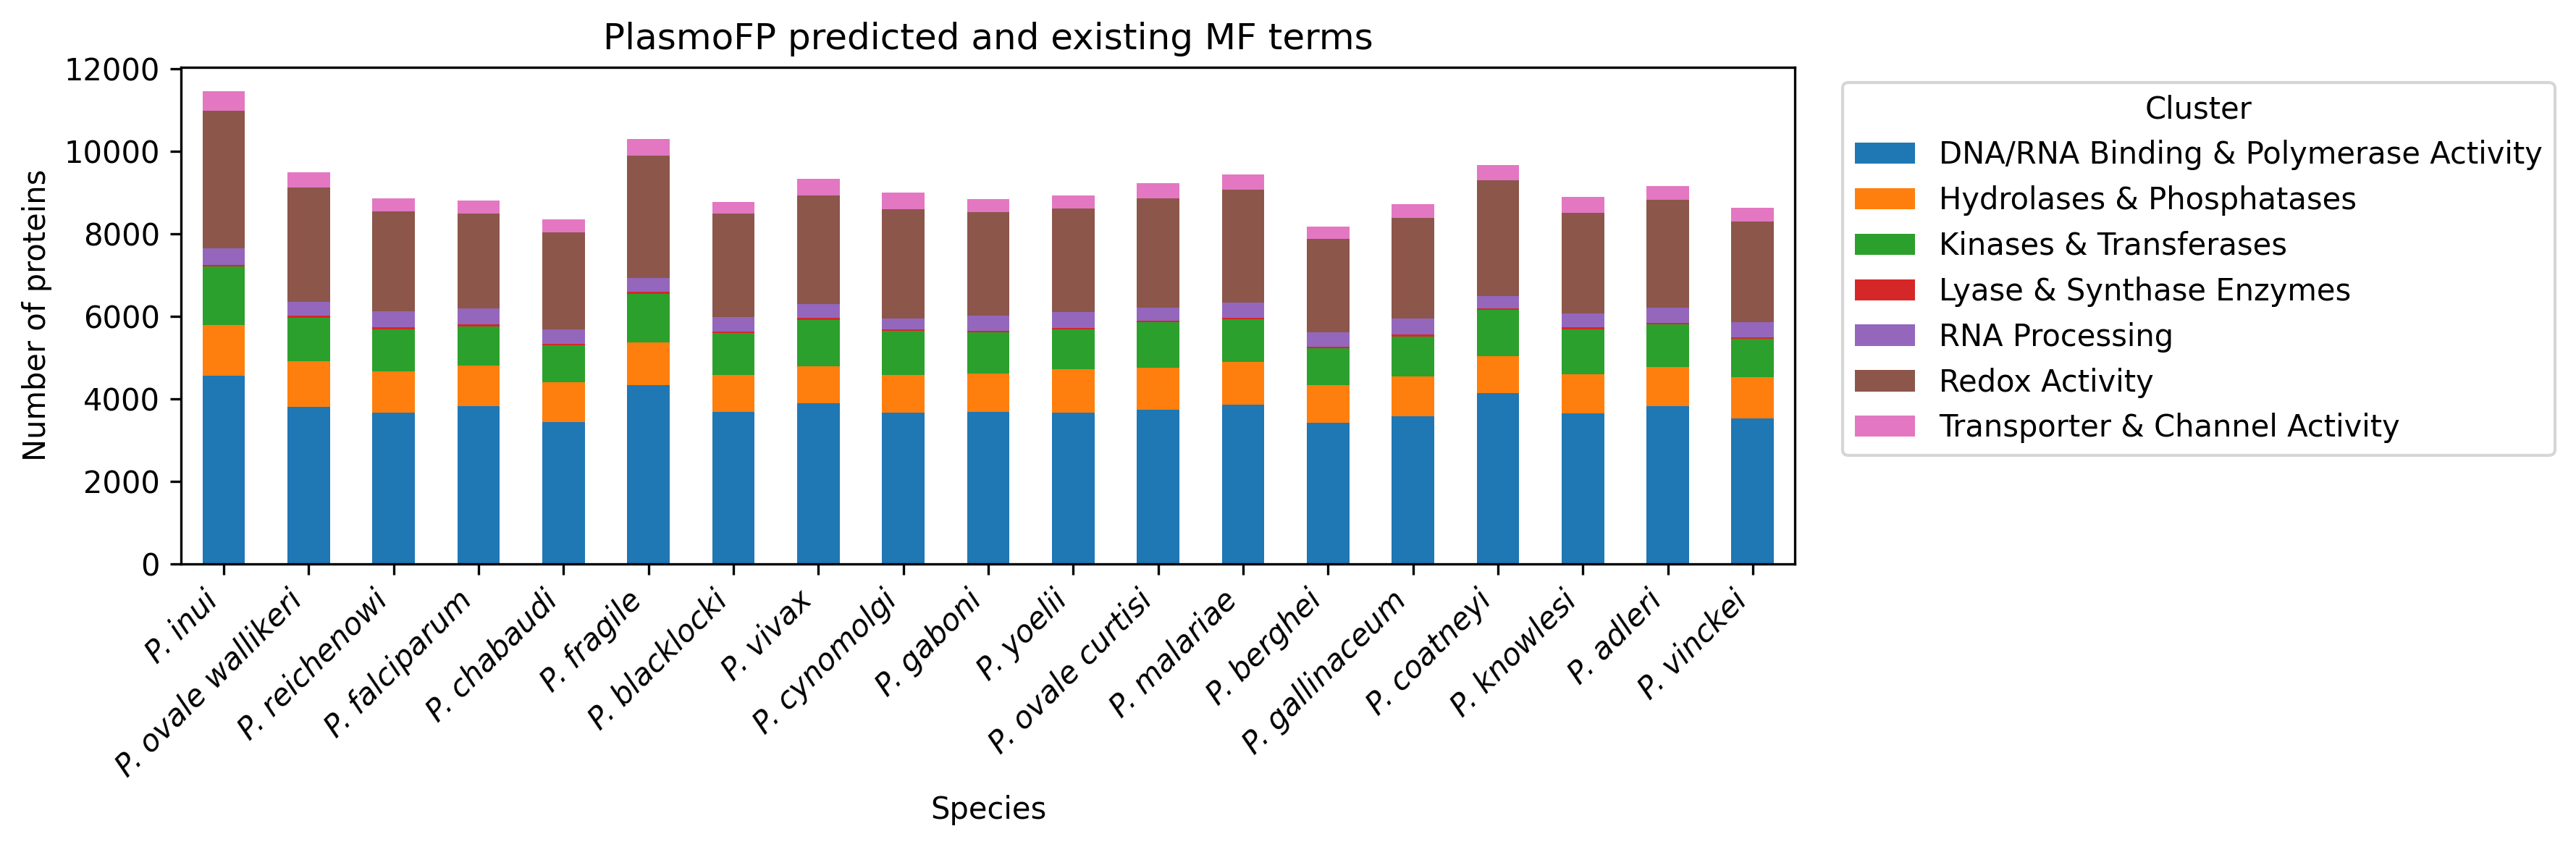

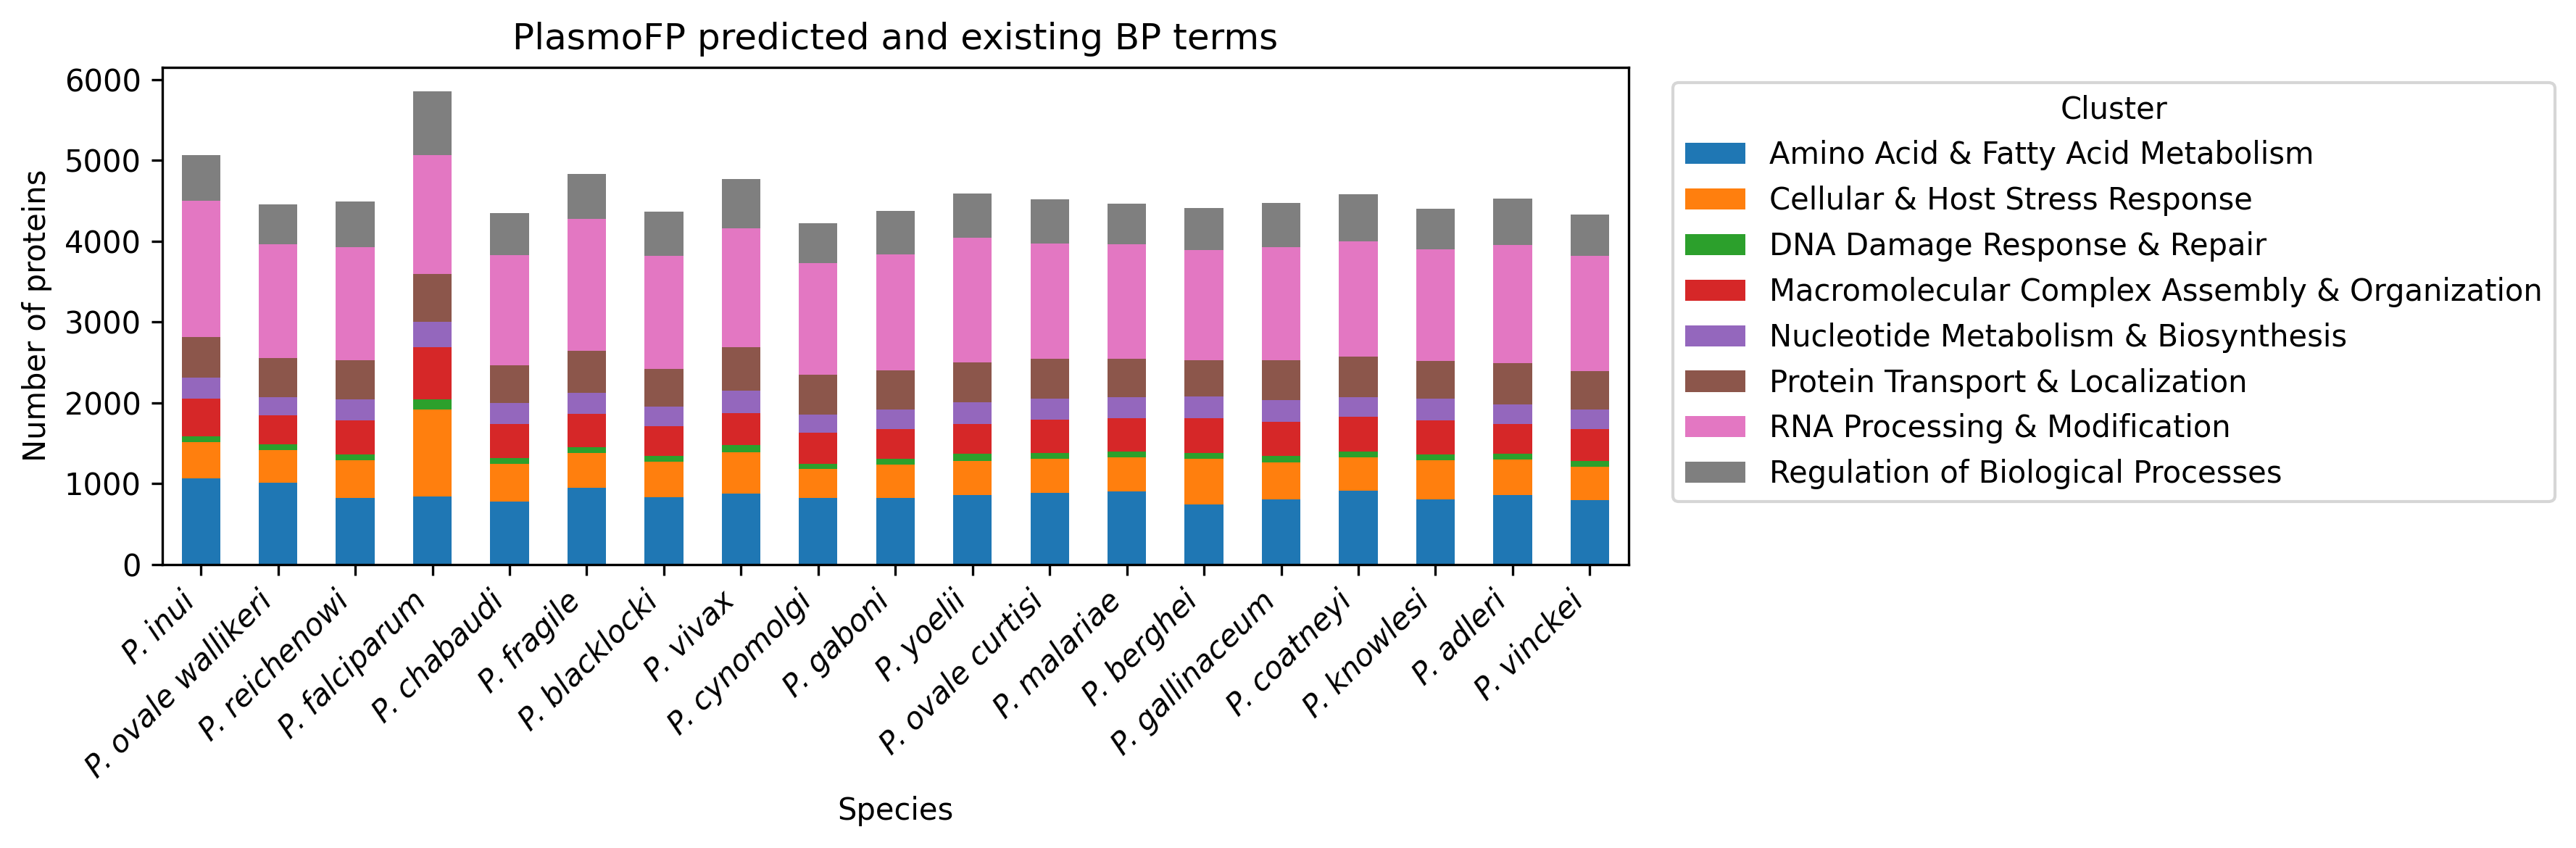

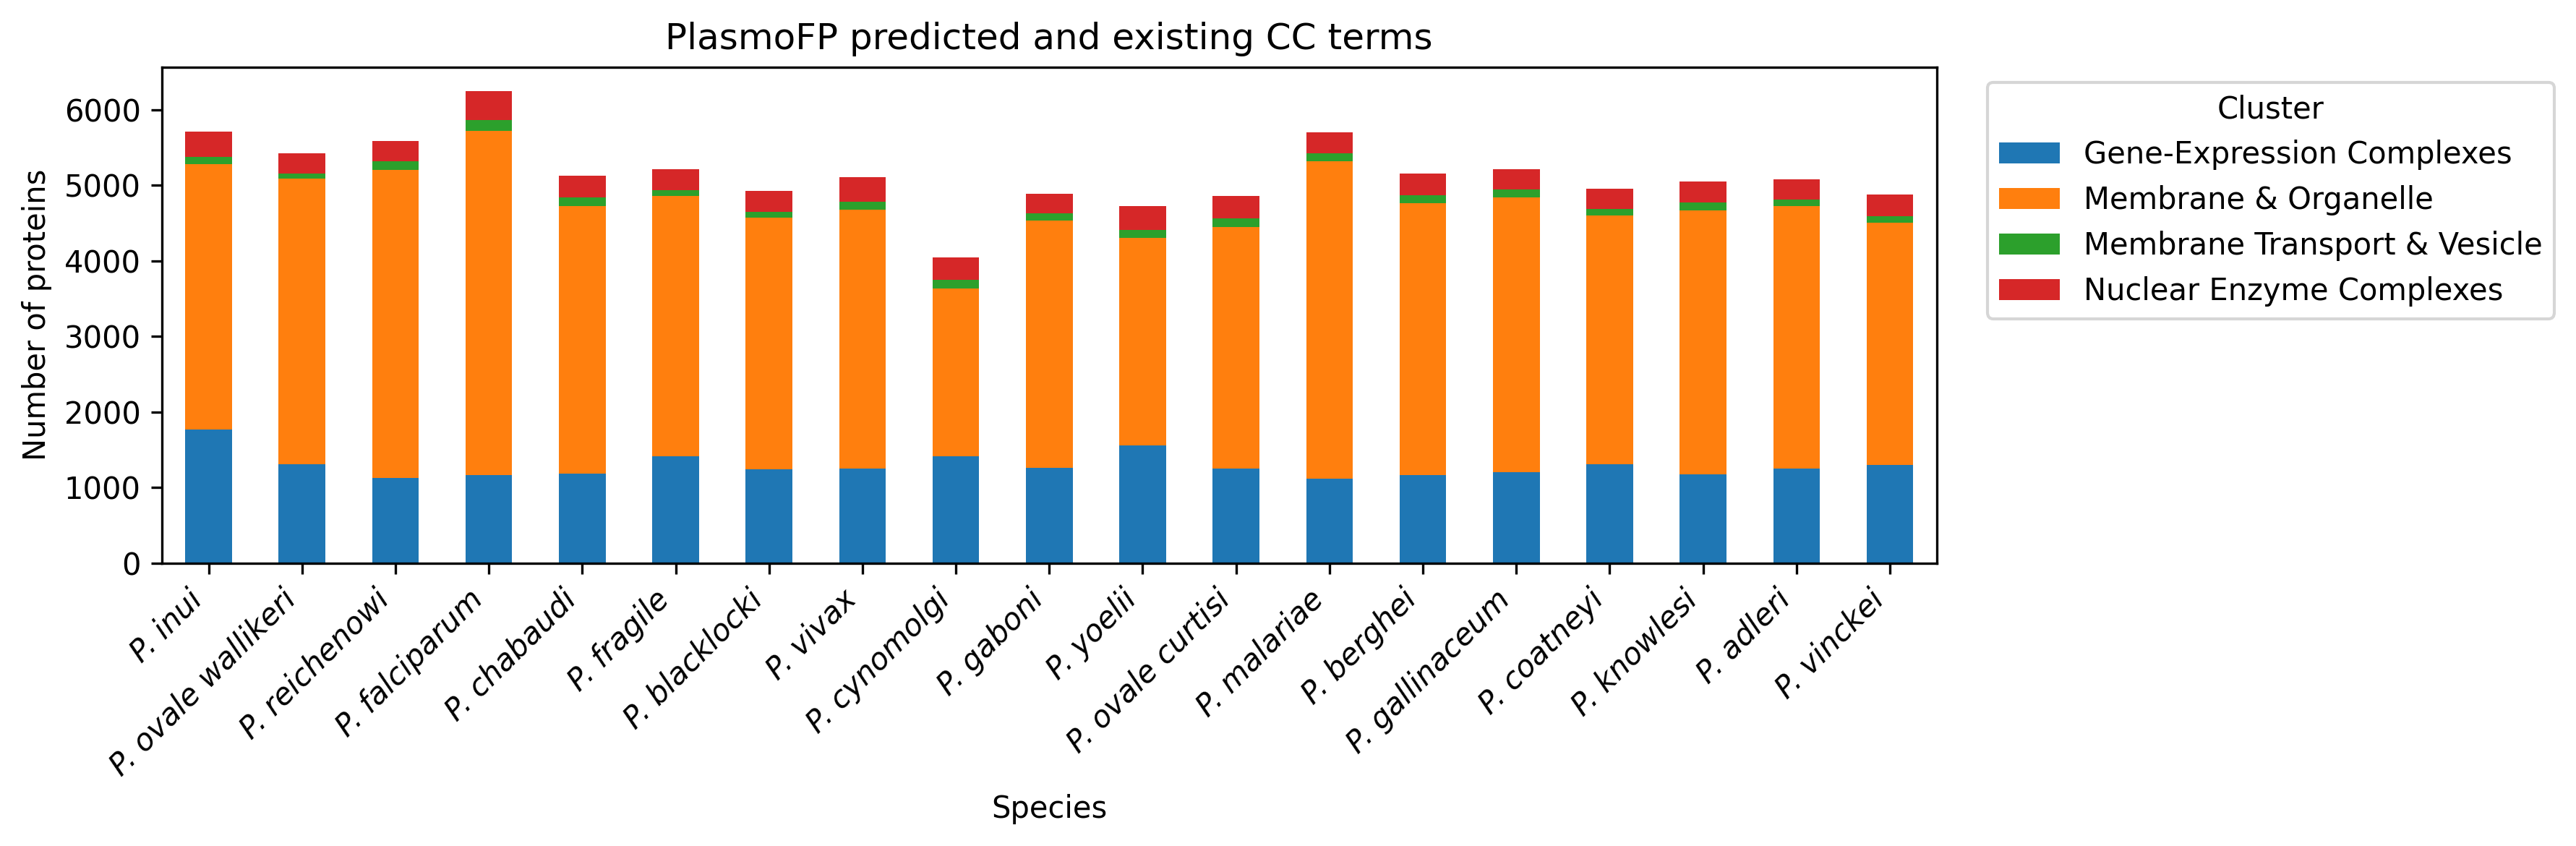

In [9]:
pfp_slots = {
    'MF': 'PFP MF',
    'BP': 'PFP BP',
    'CC': 'PFP CC'
}

all_counts = {}
for onto in ['MF','BP','CC']:
    counts = {}
    cur1, cur2 = curated_slots[onto]
    pfp_slot    = pfp_slots[onto]
    lookup      = go_to_cluster[onto]
    
    for species, genes in gene_dicts.items():
        c = Counter()
        for gid, ann in genes.items():
            go_ids = set(ann.get(cur1, []) + ann.get(cur2, []))
            
            for thresh, gos in ann.get(pfp_slot, {}).items():
                go_ids.update(go_id for go_id, *_ in gos)
            
            clusters = { lookup.get(go) for go in go_ids }
            clusters.discard(None)
            
            for cl in clusters:
                c[cl] += 1
        
        counts[species] = c
    
    df_counts = pd.DataFrame(counts).T.fillna(0).astype(int)
    df_counts = df_counts[sorted(df_counts.columns)]
    df_counts.to_csv(f'clustering_results/pfp_existing_{onto}.tsv', sep='\t')
    all_counts[onto] = df_counts

for onto, df_counts in all_counts.items():
    fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
    
    df_counts.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        title=f"PlasmoFP predicted and existing {onto} terms"
    )
    xticks = ax.get_xticks()
    friendly = [species_to_name.get(code, code) for code in df_counts.index]
    ax.set_xticks(xticks)
    ax.set_xticklabels(friendly, rotation=45, ha='right', fontstyle='italic')
    ax.set_xlabel("Species")
    ax.set_ylabel("Number of proteins")
    plt.legend(title="Cluster", bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [10]:
pct_growth = {}

for onto in ['MF','BP','CC']:
    df_cur  = all_counts_curated[onto]
    df_comb = all_counts[onto]
    
    df_cur_aligned, df_comb_aligned = df_cur.align(df_comb, fill_value=0)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        df_pct = (df_comb_aligned - df_cur_aligned) \
                 .divide(df_cur_aligned) * 100
    
    # wherever df_cur was zero:
    #  - leave as NaN
    #  - set to 100 (i.e. “from 0 to X is 100% growth”)
    #  - set to df_comb (interpret as “infinite”)
    
    pct_growth[onto] = df_pct
    
    print(f"\n=== {onto} percent growth (combined vs. curated) ===")
    print(df_pct)


=== MF percent growth (combined vs. curated) ===
                                    DNA/RNA Binding & Polymerase Activity  \
PlasmoDB-68_PinuiSanAntonio1                                   210.211028   
PlasmoDB-68_PovalewallikeriPowCR01                             172.851003   
PlasmoDB-68_PreichenowiCDC                                     116.913947   
PlasmoDB-68_Pfalciparum3D7                                      73.705722   
PlasmoDB-68_Pchabaudichabaudi                                  123.586745   
PlasmoDB-68_PfragileNilgiri                                    190.354990   
PlasmoDB-68_PblacklockiG01                                     138.766234   
PlasmoDB-68_PvivaxSal1                                         126.135041   
PlasmoDB-68_PcynomolgiM                                        181.149425   
PlasmoDB-68_PgaboniG01                                         133.502217   
PlasmoDB-68_Pyoeliiyoelii17XNL2023                             116.963227   
PlasmoDB-68_PovalecurtisiG

In [11]:
print(pct_growth['CC'].mean())
print(pct_growth['BP'].mean())
print(pct_growth['MF'].mean())

Gene-Expression Complexes       434.097931
Membrane & Organelle             77.001207
Membrane Transport & Vesicle     33.215597
Nuclear Enzyme Complexes         86.411053
dtype: float64
Amino Acid & Fatty Acid Metabolism                147.033925
Cellular & Host Stress Response                   131.495629
DNA Damage Response & Repair                       12.365720
Macromolecular Complex Assembly & Organization    144.489913
Nucleotide Metabolism & Biosynthesis               33.711817
Protein Transport & Localization                  100.346807
RNA Processing & Modification                     132.279135
Regulation of Biological Processes                282.657286
dtype: float64
DNA/RNA Binding & Polymerase Activity    143.329011
Hydrolases & Phosphatases                128.741018
Kinases & Transferases                   181.497290
Lyase & Synthase Enzymes                  12.991481
RNA Processing                            65.659129
Redox Activity                           400.64221

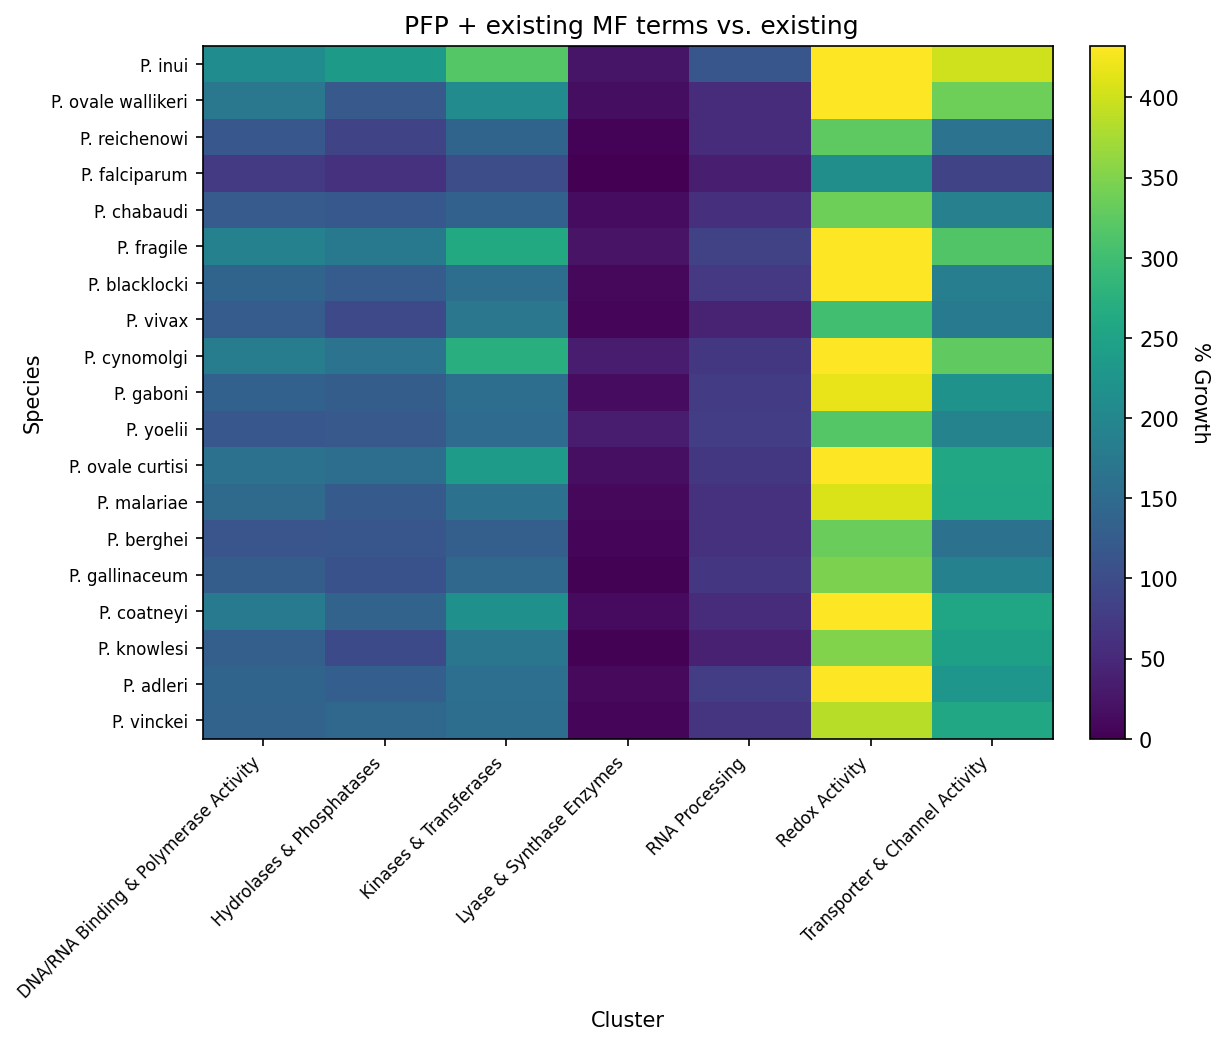

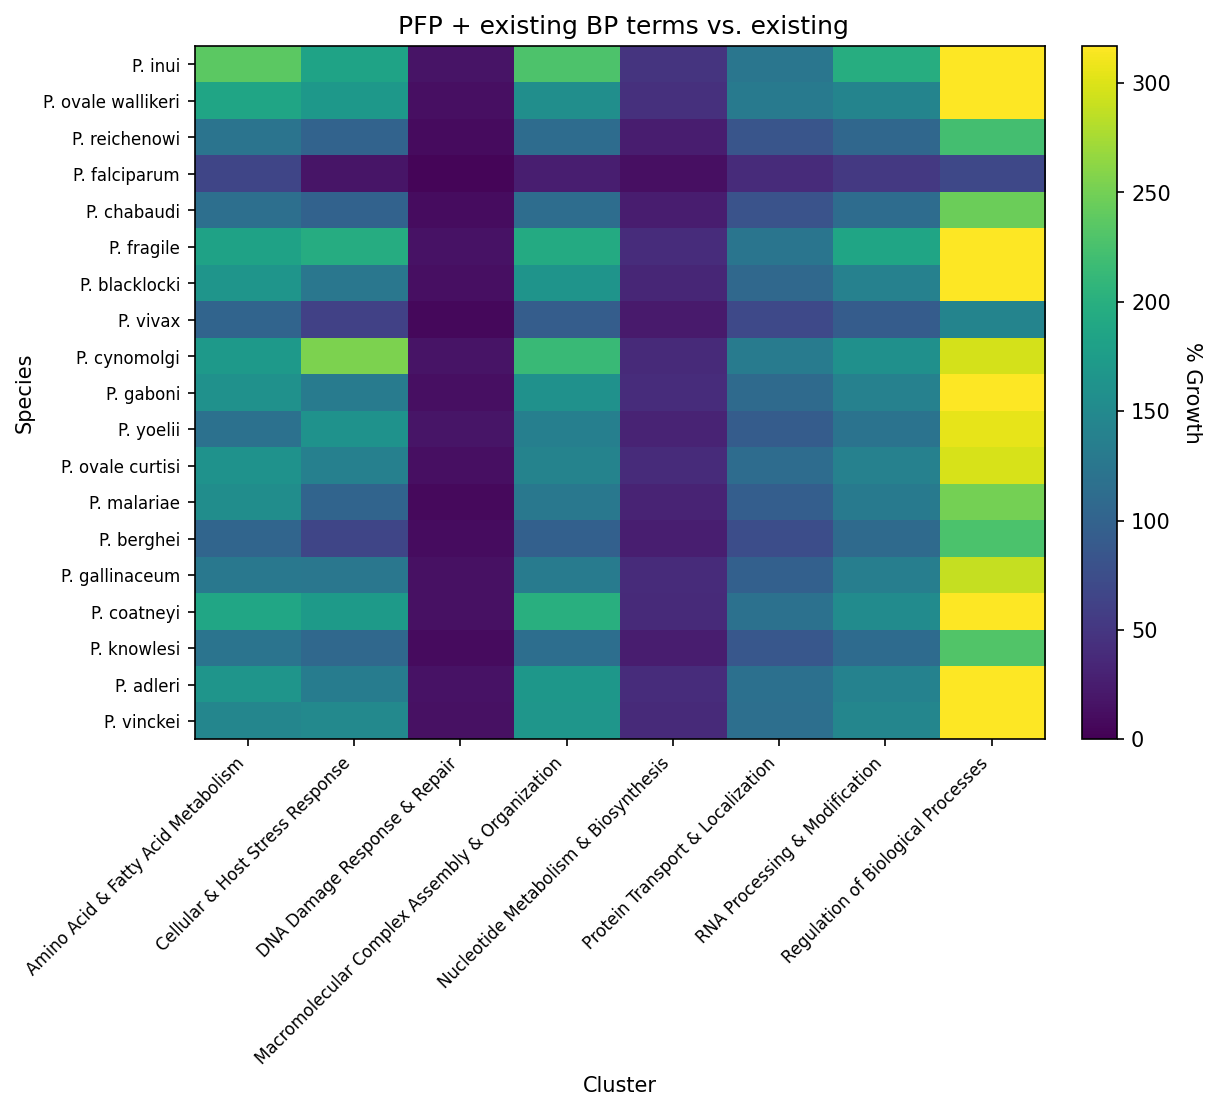

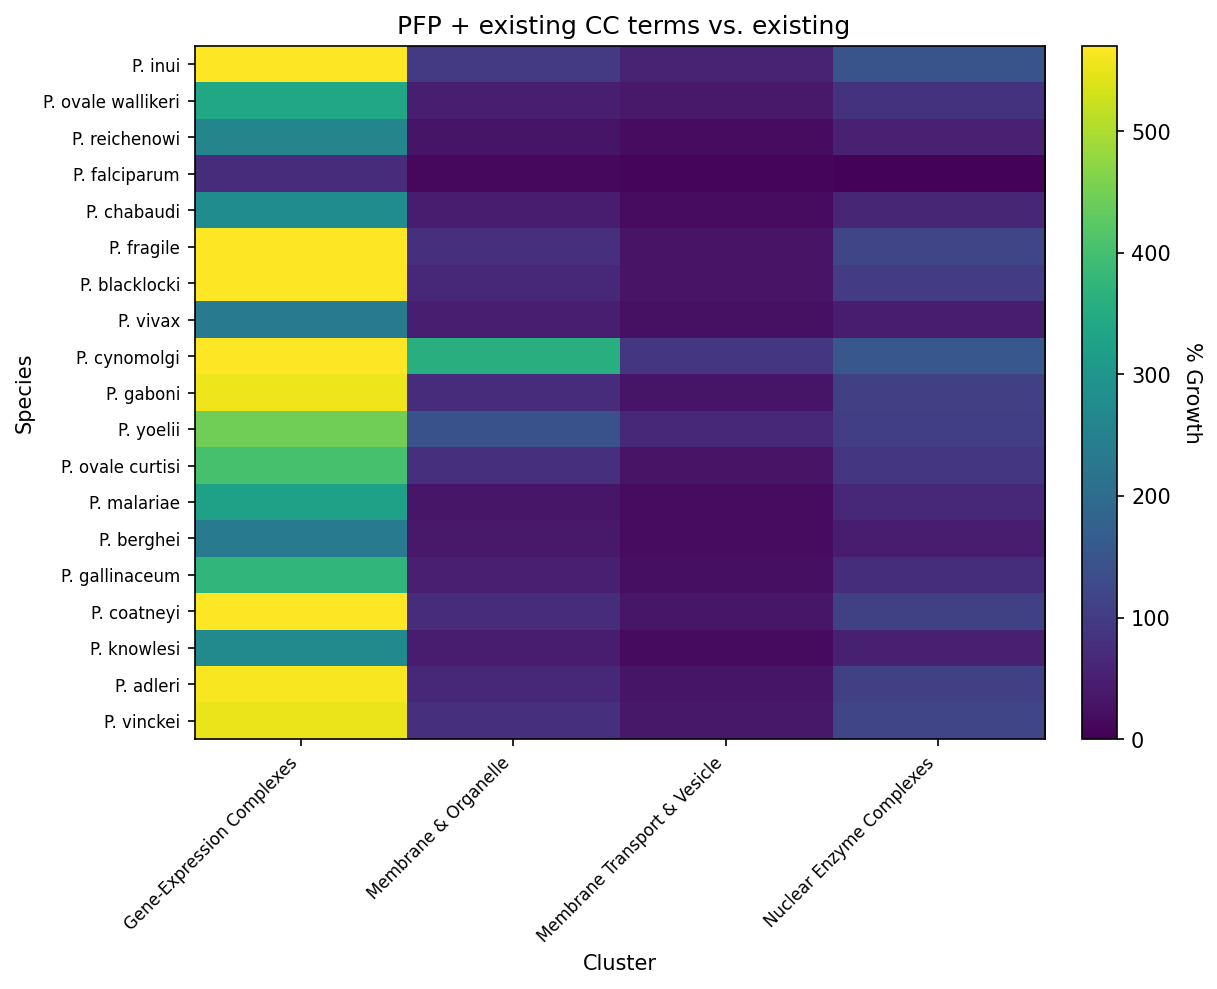

In [12]:
for onto, df_pct in pct_growth.items():
    data = df_pct.values
    species = df_pct.index.tolist()
    clusters = df_pct.columns.tolist()

    fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
    im = ax.imshow(data, aspect='auto', cmap='viridis', 
                   vmin=0, vmax=np.nanpercentile(data, 95))  # clip at 95th pct for color contrast

    ax.set_yticks(np.arange(len(species)))
    ax.set_yticklabels([species_to_name.get(s, s) for s in species], fontsize=8)
    ax.set_xticks(np.arange(len(clusters)))
    ax.set_xticklabels(clusters, rotation=45, ha='right', fontsize=8)

    ax.set_title(f" PFP + existing {onto} terms vs. existing")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Species")

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('% Growth', rotation=270, labelpad=15)

    plt.show()

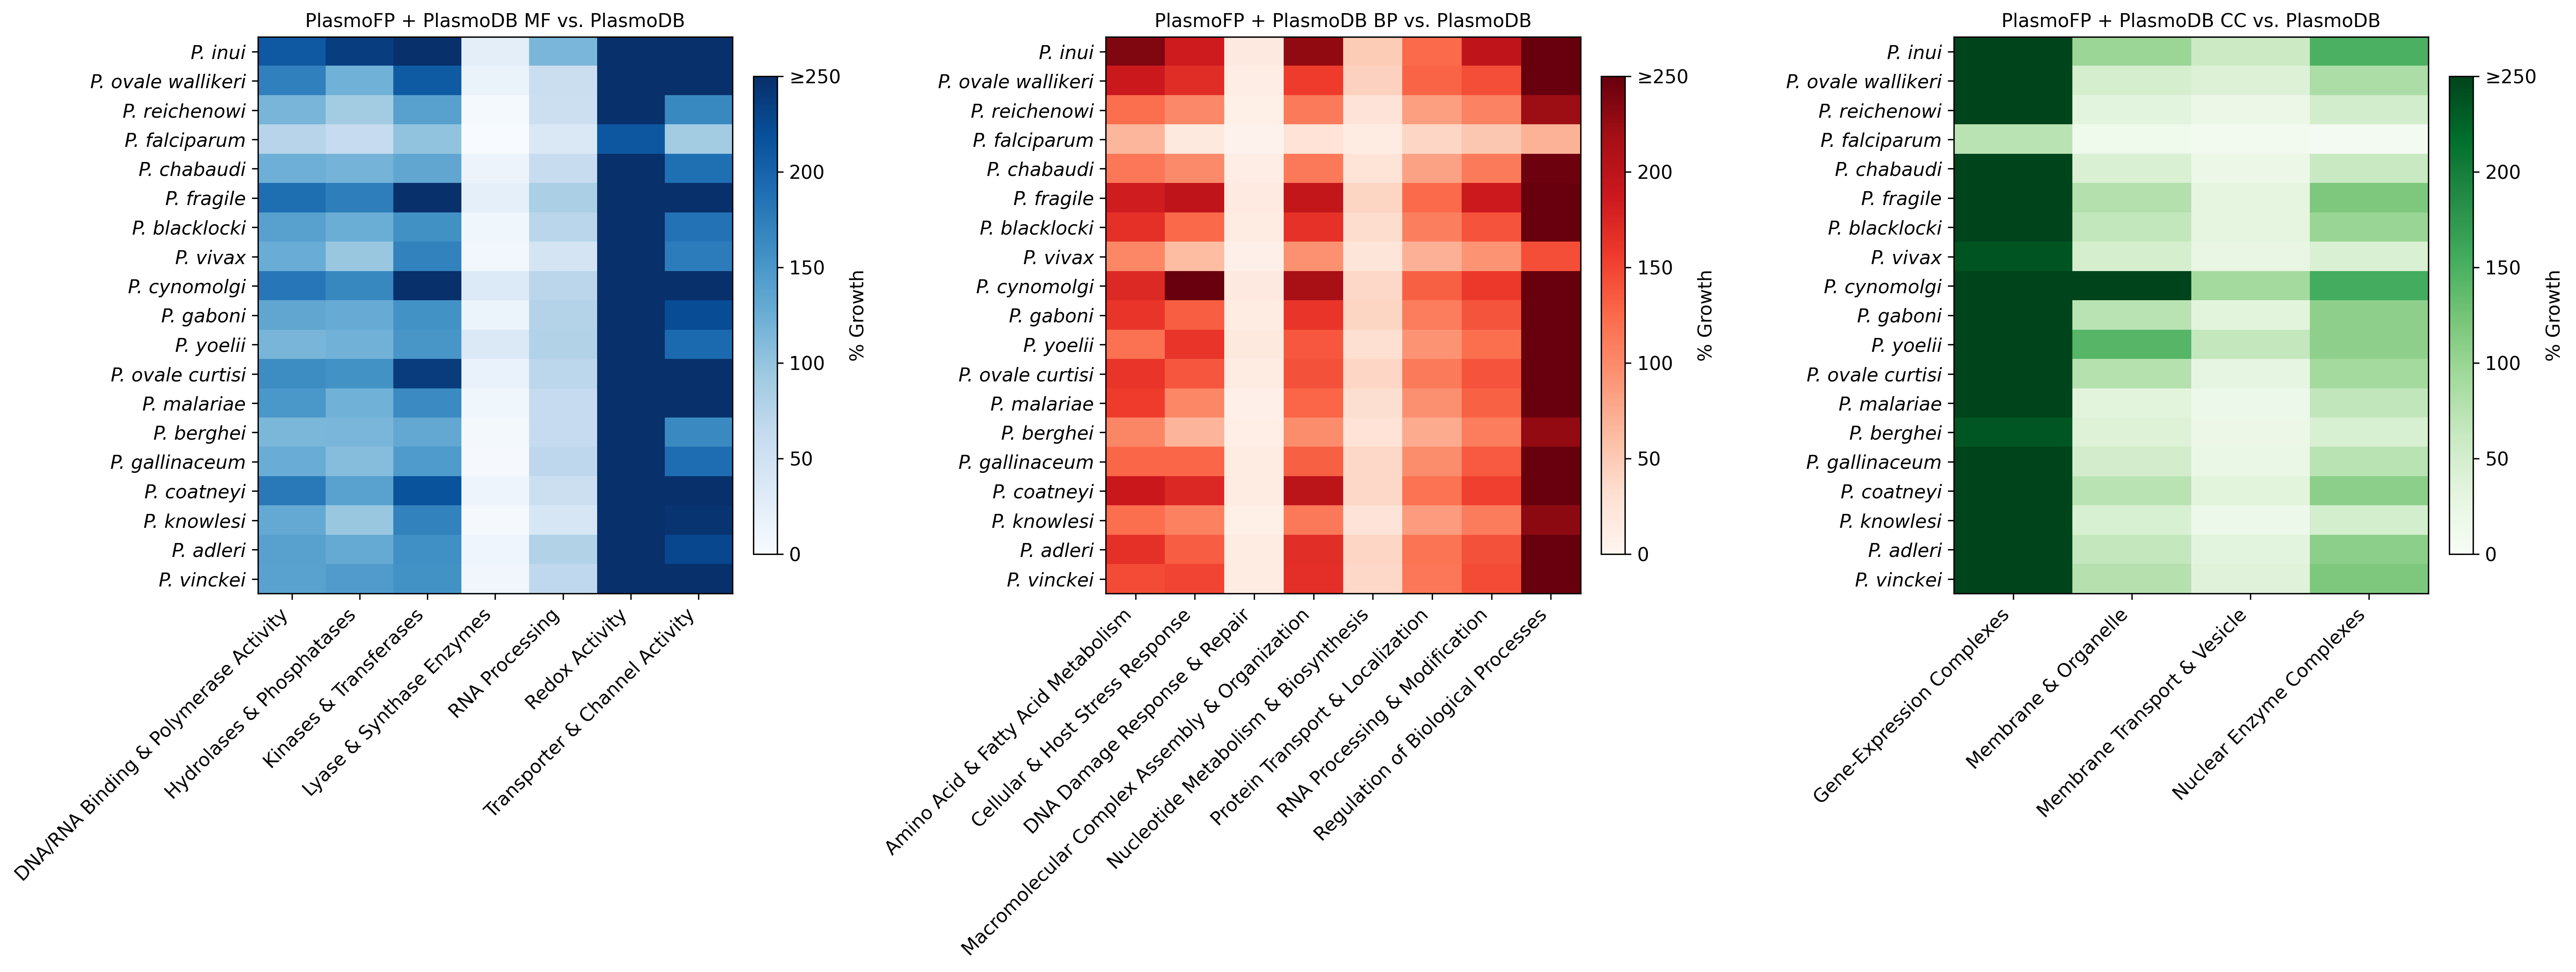

In [ ]:
ONTO_ORDER = ['MF','BP','CC']
HEATMAP_CM = {'MF':'Blues','BP':'Reds','CC':'Greens'}
dpi = 300

fig, axes = plt.subplots(1, 3, figsize=(21, 8), dpi=dpi, sharey=False)
for ax, onto in zip(axes, ONTO_ORDER):
    df = pct_growth[onto]
    data = df.values

    im = ax.imshow(
        data,
        aspect='auto',
        cmap=HEATMAP_CM[onto],
        vmin=0,
        vmax=250  # cap at 300%
    )

    ax.set_title(f"PlasmoFP + PlasmoDB {onto} vs. PlasmoDB", fontsize=11)

    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(
        [species_to_name.get(s, s) for s in df.index],
        fontstyle='italic',
        fontsize=11
    )

    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(
        df.columns,
        rotation=45,
        ha='right',
        fontsize=11
    )

    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ticks = cbar.get_ticks()

    # replace the top tick with "≥300"
    new_labels = [f"{t:.0f}" for t in ticks]
    if ticks[-1] >= 200:
        new_labels[-1] = "≥250"

    cbar.set_ticks(ticks)
    cbar.set_ticklabels(new_labels)
    cbar.set_label('% Growth', rotation=90, labelpad=5, fontsize=11)
    cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.show()


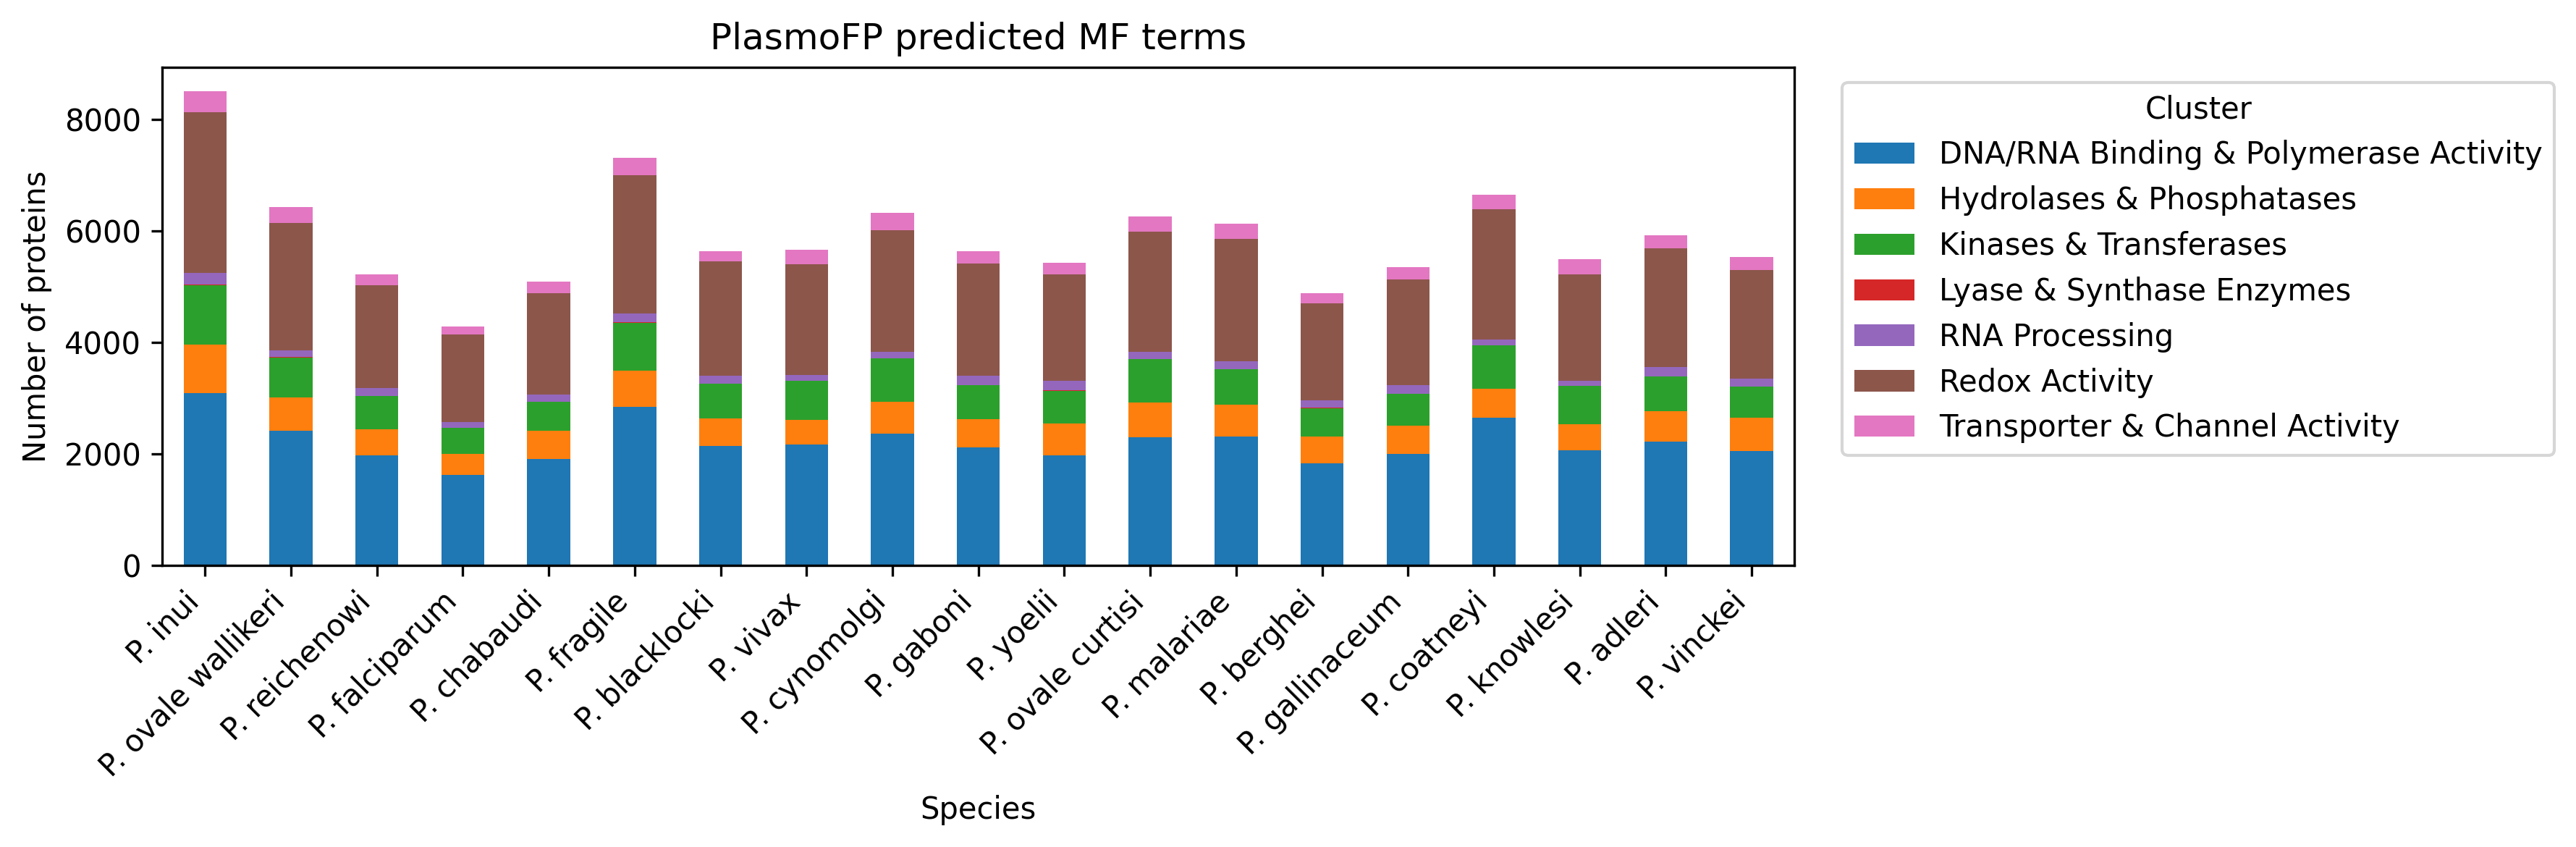

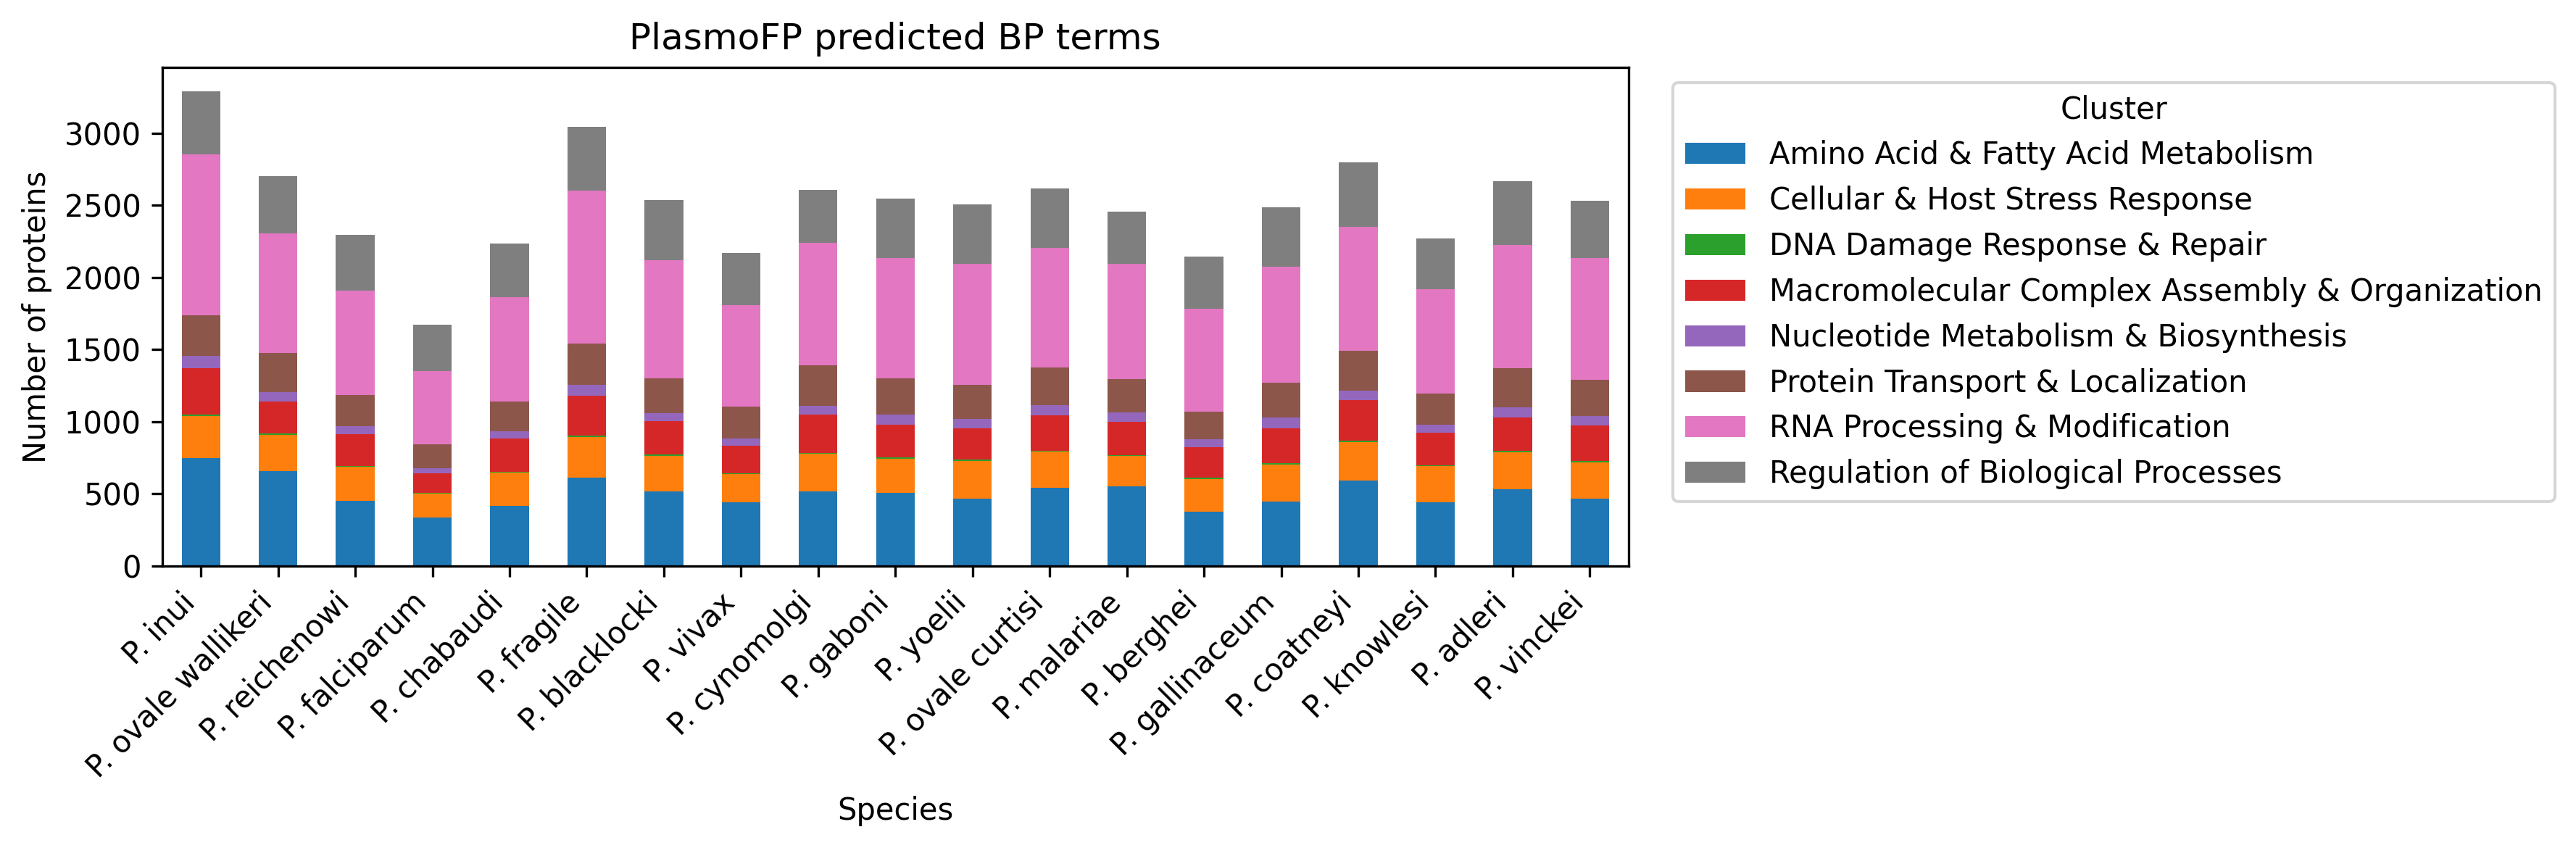

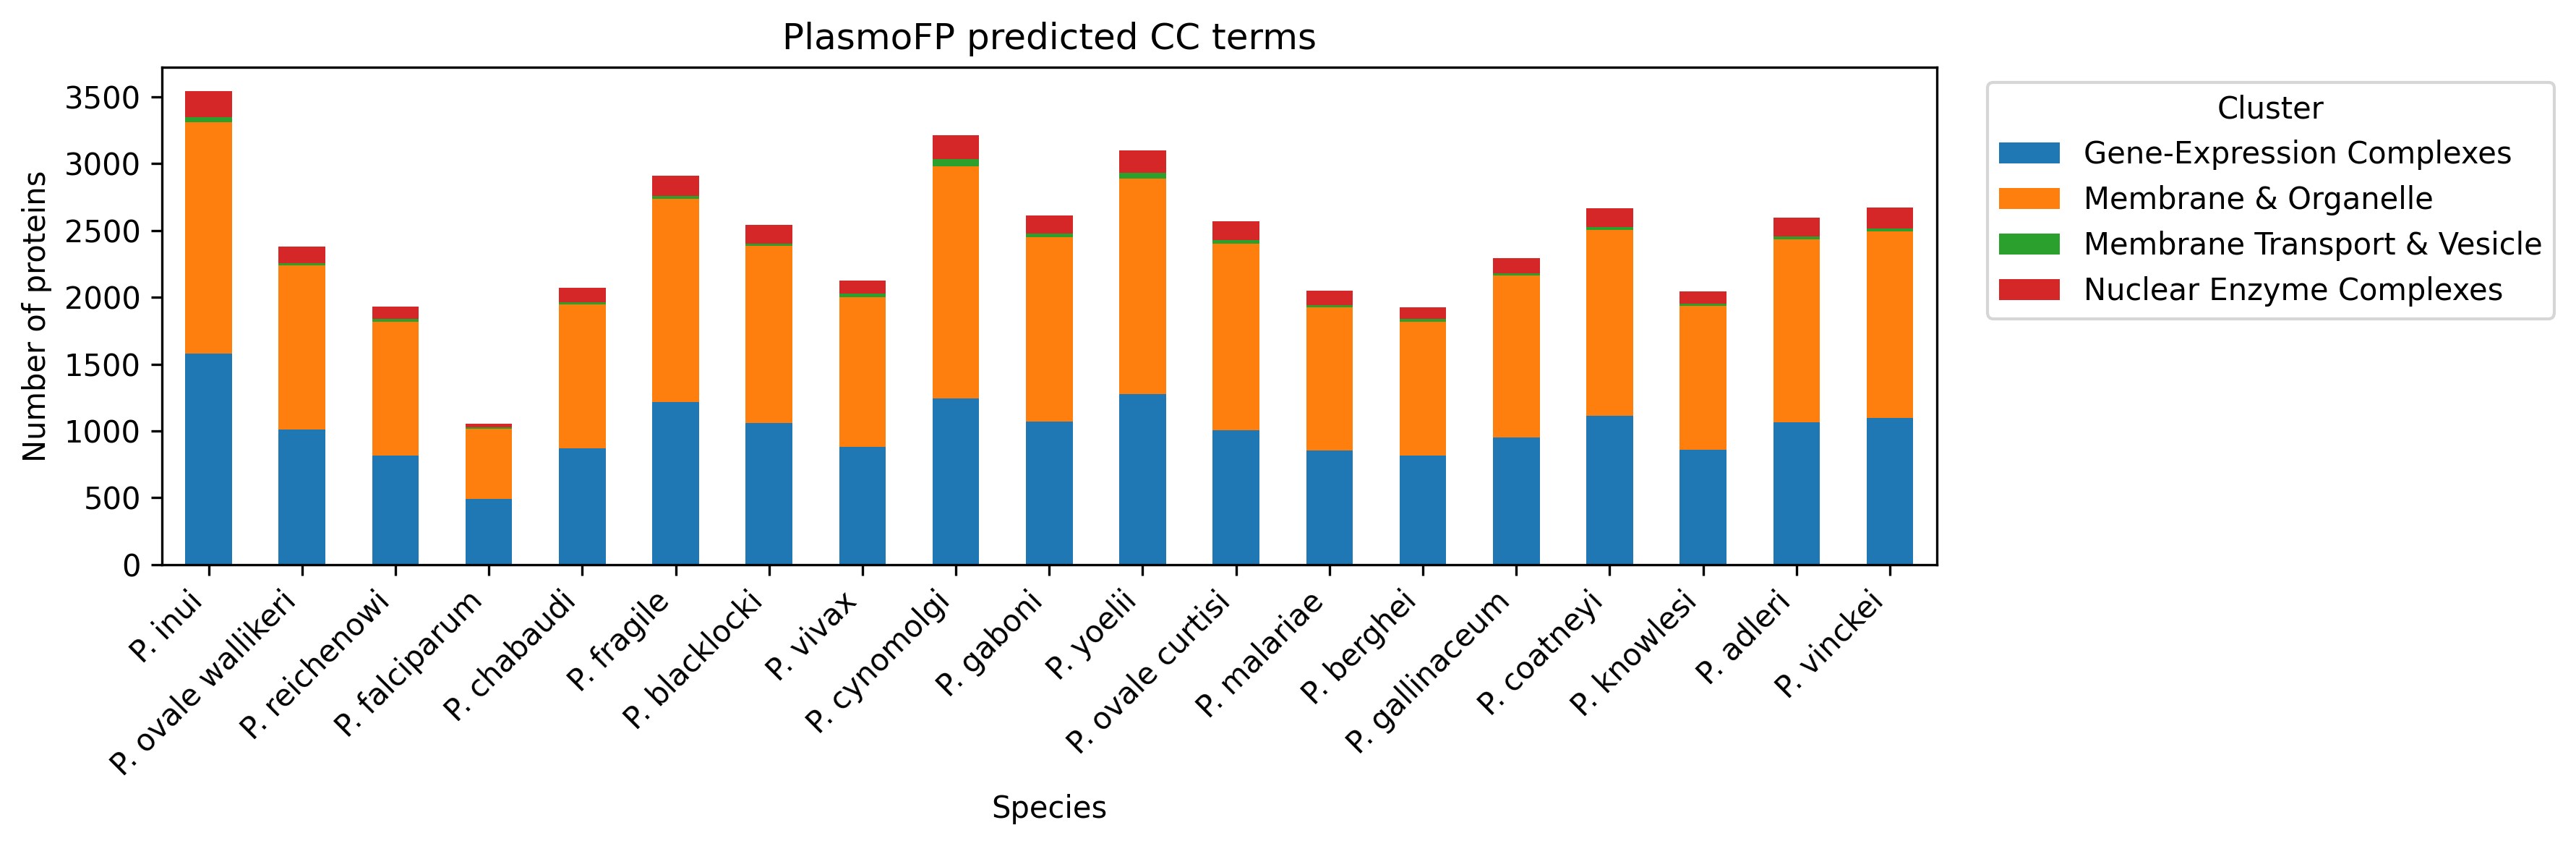

In [19]:
cluster_dfs = {
    'MF': mf_clusters,
    'BP': bp_clusters,
    'CC': cc_clusters
}

go_to_cluster = {}
for onto, df in cluster_dfs.items():
    go_to_cluster[onto] = dict(zip(df['GO_ID'], df['ClusterName']))

all_counts = {}
for onto, slot in pfp_slots.items():
    counts = {} 
    for species, genes in gene_dicts.items():
        from collections import Counter
        c = Counter()
        for gid, ann in genes.items():
            go_ids = set()
            for thresh, gos in ann.get(slot, {}).items():
                go_ids.update(go_id for go_id, *_ in gos)
            clusters = {go_to_cluster[onto].get(go) for go in go_ids}
            clusters.discard(None)
            for cl in clusters:
                c[cl] += 1
        counts[species] = c
    df_counts = pd.DataFrame(counts).T.fillna(0).astype(int)
    df_counts.to_csv(f'clustering_results/pfp_only{onto}.tsv', sep='\t')
    df_counts = df_counts[sorted(df_counts.columns)]
    all_counts[onto] = df_counts

for onto, df_counts in all_counts.items():
    fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
    
    df_counts.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        title=f"PlasmoFP predicted {onto} terms"
    )
    xticks = ax.get_xticks()
    friendly = [species_to_name.get(code, code) for code in df_counts.index]
    ax.set_xticks(xticks)
    ax.set_xticklabels(friendly, rotation=45, ha='right')
    ax.set_xlabel("Species")
    ax.set_ylabel("Number of proteins")
    plt.legend(title="Cluster", bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()


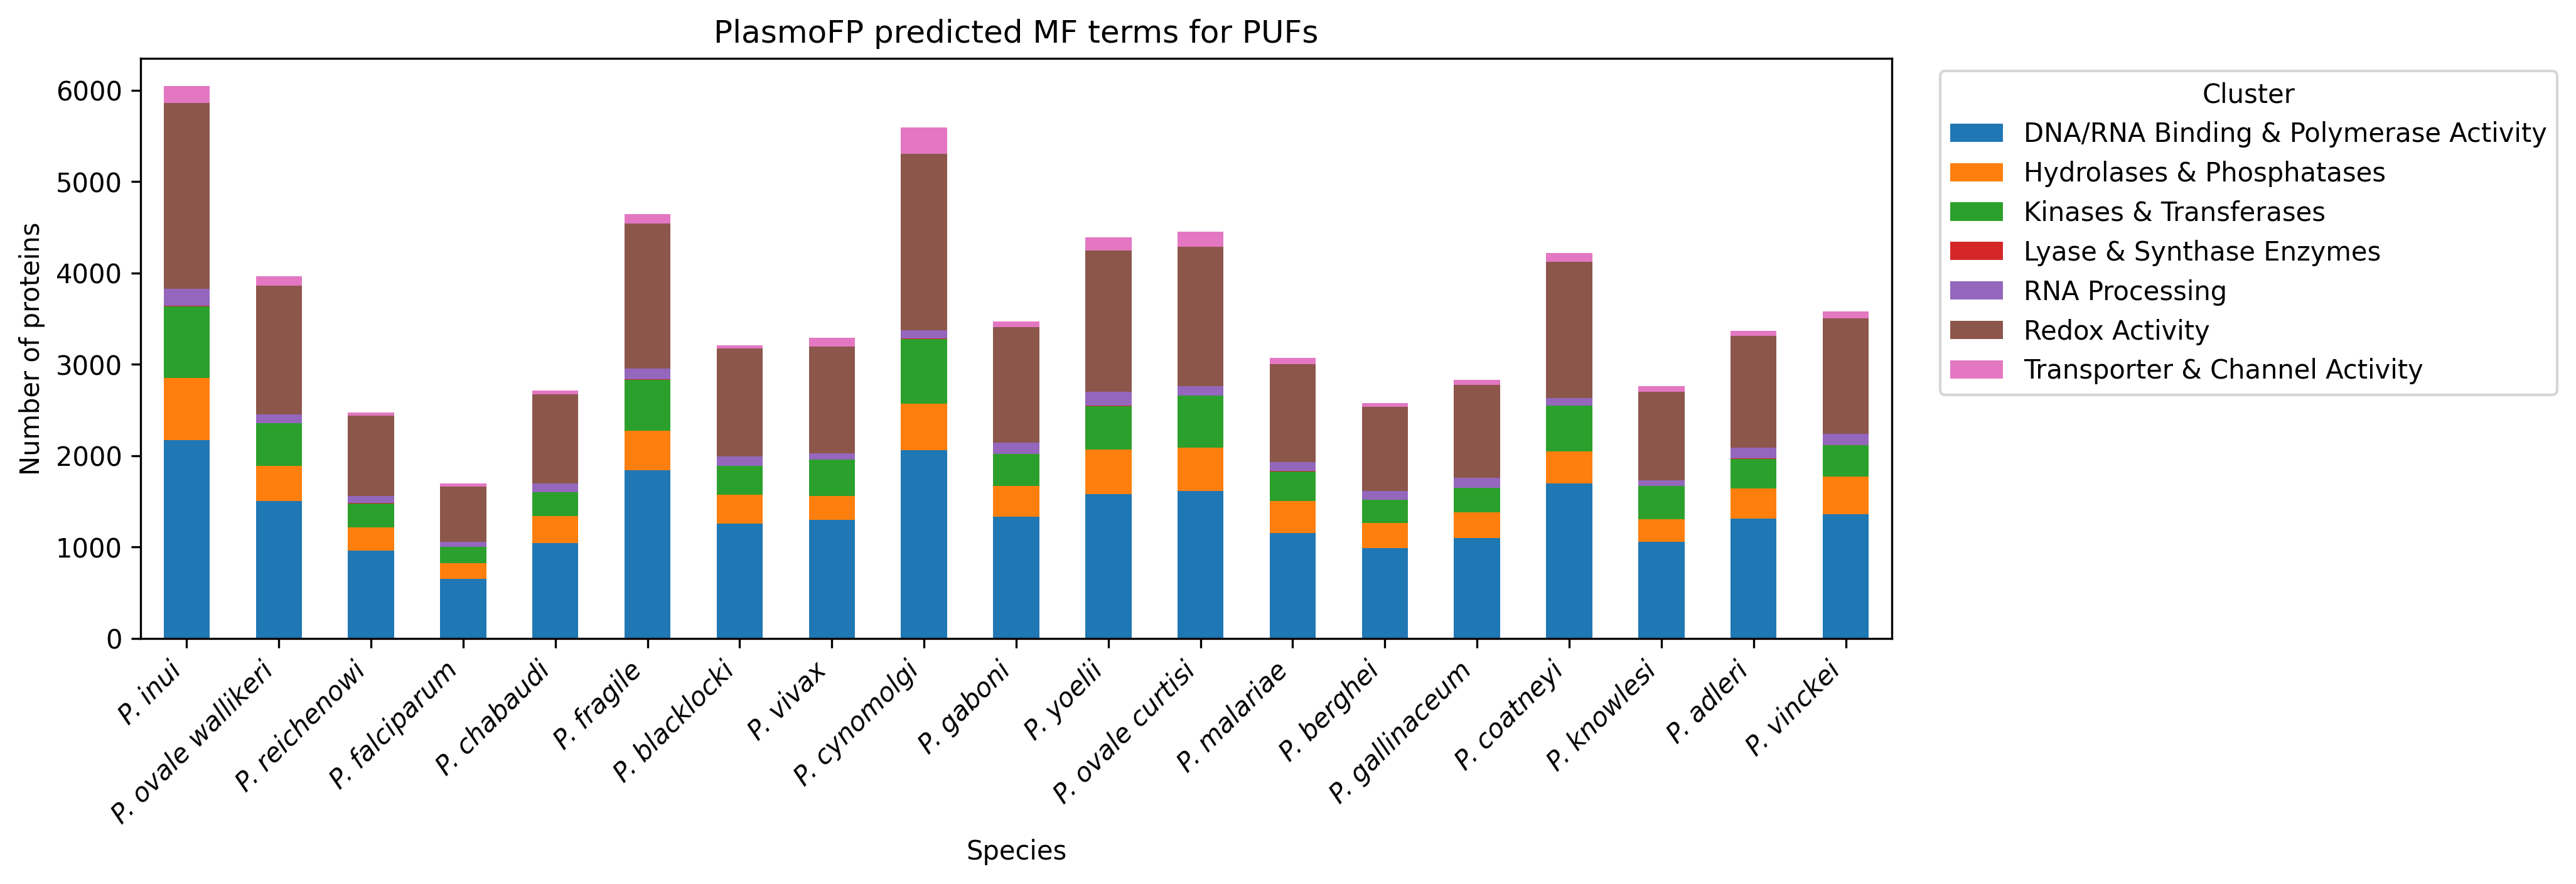

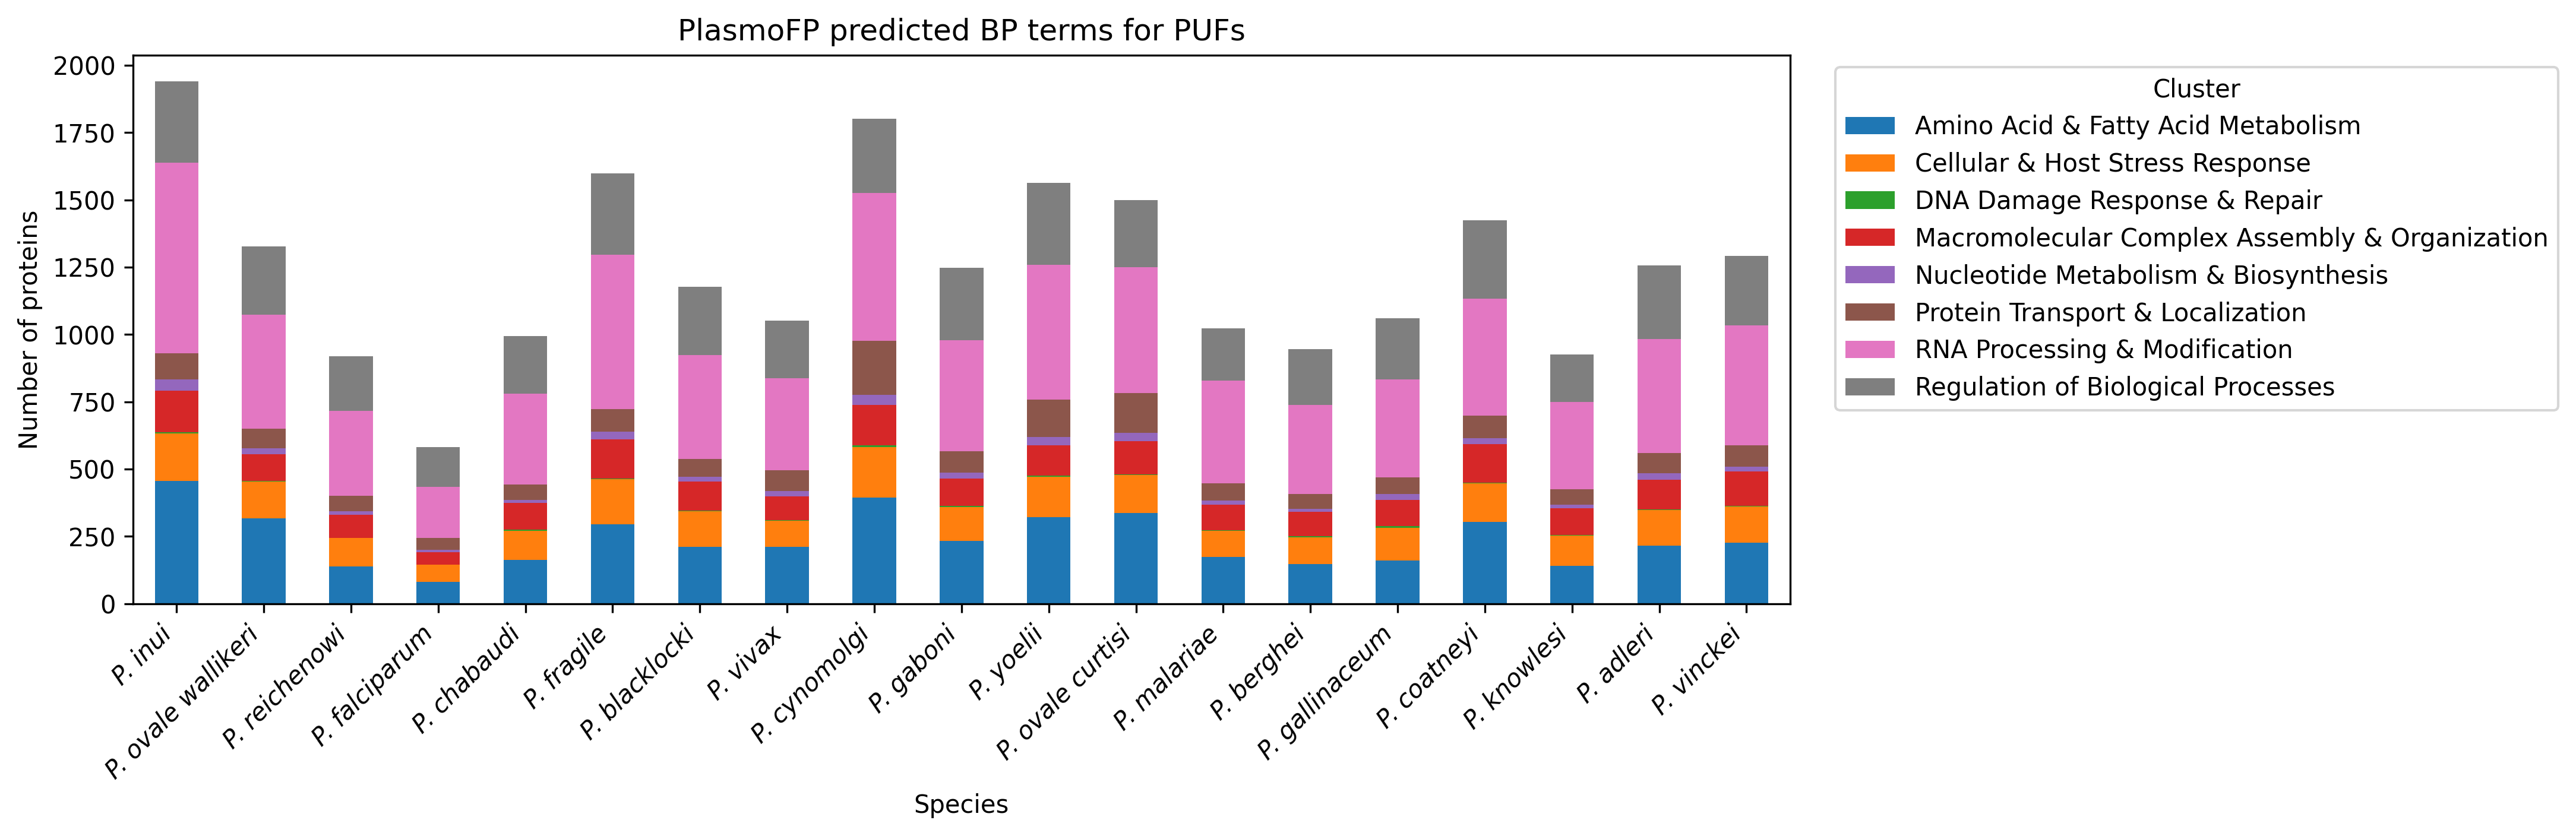

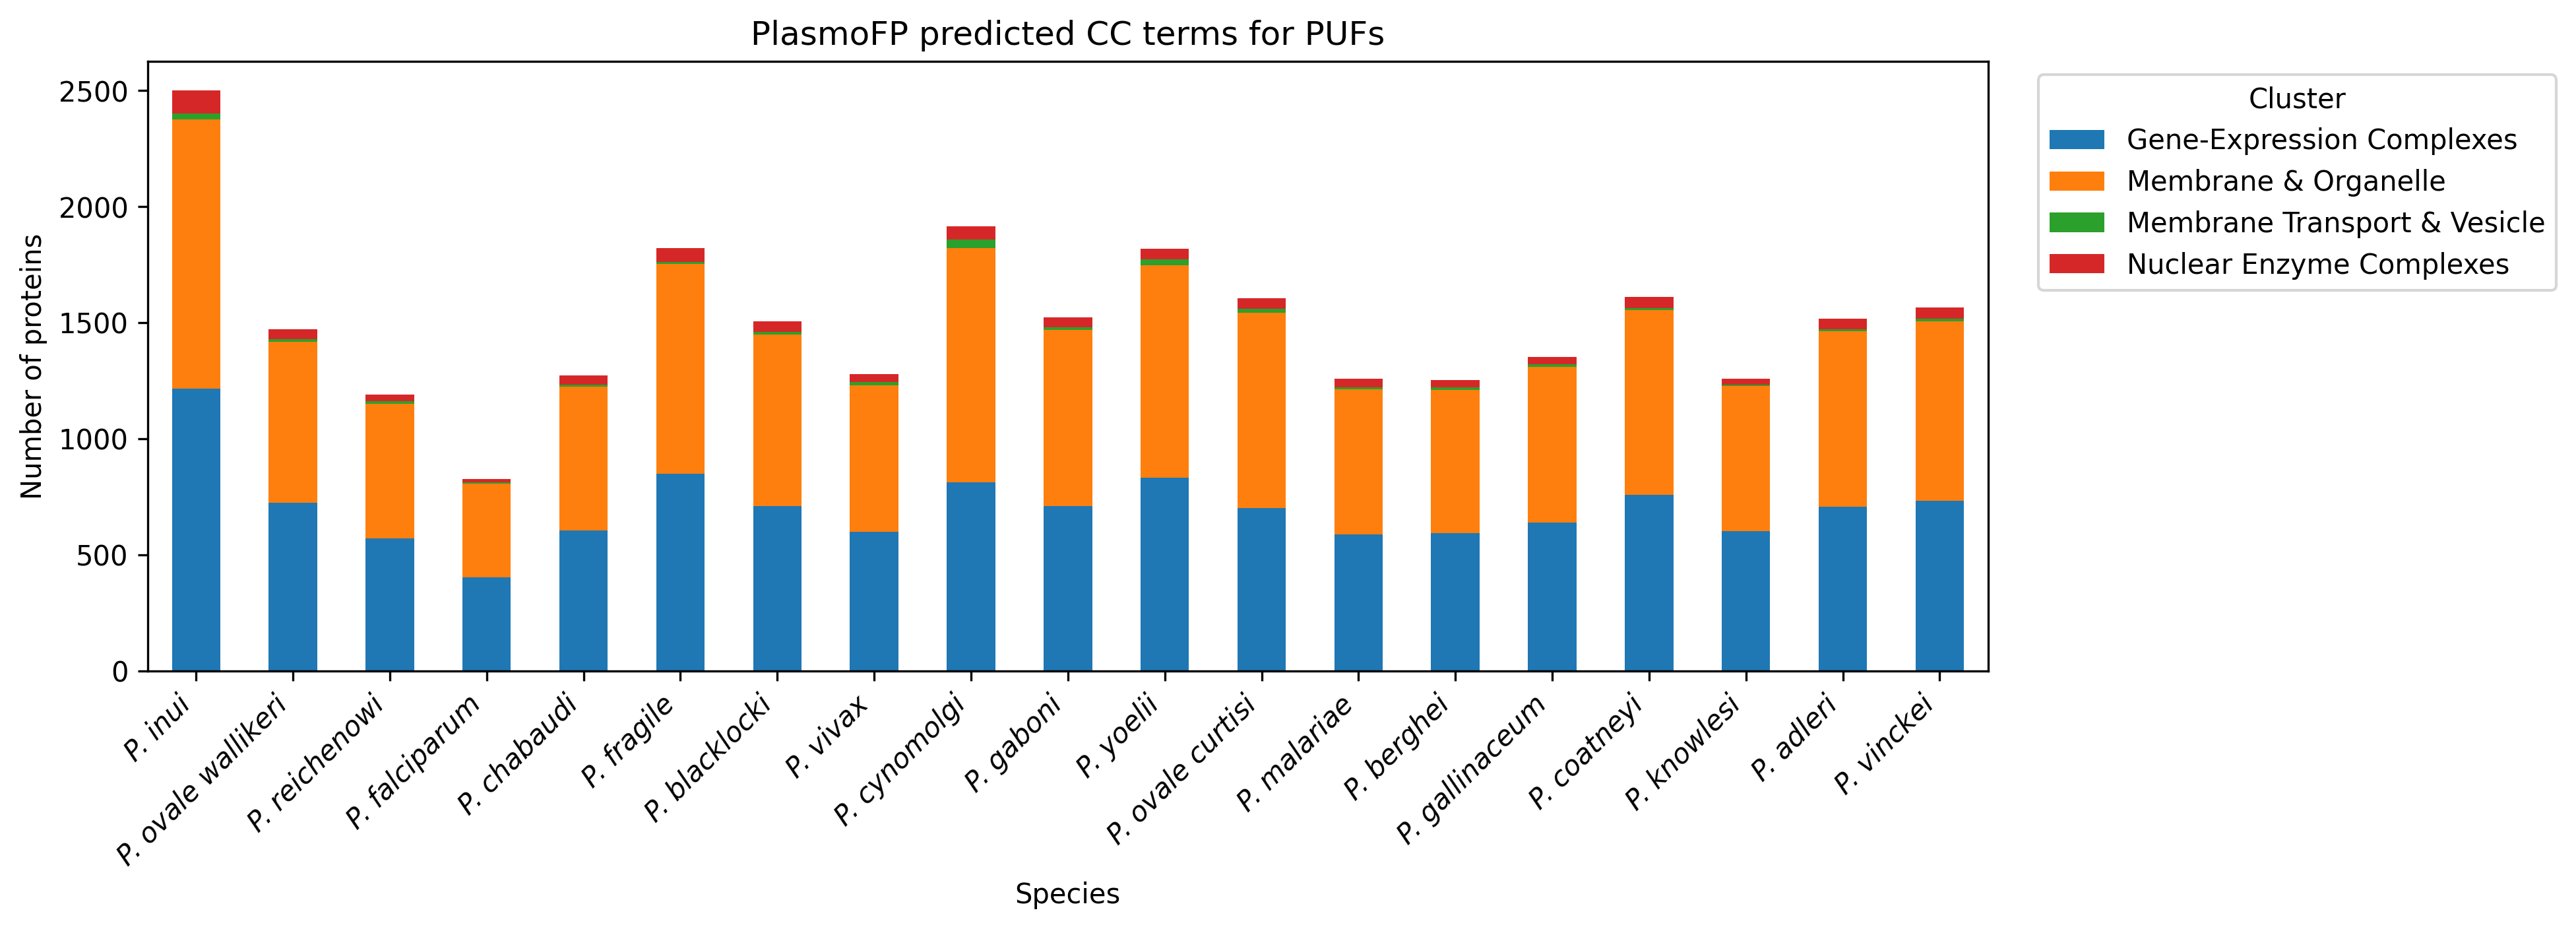

In [20]:
all_counts = {}
for onto, slot in pfp_slots.items():
    counts = {}
    for species, genes in gene_dicts.items():
        c = Counter()
        for gid in puf_genes.get(species, []):
            ann = genes[gid]
            go_ids = set(
                go_id
                for thresh, gos in ann.get(slot, {}).items()
                for go_id, *_ in gos
            )
            clusters = {go_to_cluster[onto].get(go) for go in go_ids}
            clusters.discard(None)
            for cl in clusters:
                c[cl] += 1
        counts[species] = c

    df_counts = pd.DataFrame(counts).T.fillna(0).astype(int)
    df_counts = df_counts[sorted(df_counts.columns)]
    df_counts.to_csv(f'clustering_results/pfp_PUFs_{onto}.tsv', sep='\t')
    all_counts[onto] = df_counts

for onto, df_counts in all_counts.items():
    fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
    
    df_counts.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        title=f"PlasmoFP predicted {onto} terms for PUFs"
    )
    xticks = ax.get_xticks()
    friendly = [species_to_name.get(code, code) for code in df_counts.index]
    ax.set_xticks(xticks)
    ax.set_xticklabels(friendly, rotation=45, ha='right', fontstyle='italic')
    ax.set_xlabel("Species")
    ax.set_ylabel("Number of proteins")
    plt.legend(title="Cluster", bbox_to_anchor=(1.02,1), loc='upper left')
    plt.show()

# Protease

In [32]:
#use python query_go_terms_enhanced.py
df = pd.read_csv('protease_GO_terms_raw.csv')

human_malaria = [
    'P. falciparum',
    'P. vivax',
    'P. malariae',
    'P. ovale curtisi',
    'P. ovale wallikeri'
]
target_terms = {
    "Term GO:0008237": "metallopeptidase activity",
    "Term GO:0008236": "serine-type peptidase activity",
    "Term GO:0008234": "cysteine-type peptidase activity",
    "Term GO:0004298": "threonine-type endopeptidase activity",
    "Term GO:0070001": "aspartic-type peptidase activity"
}
df['GO_Name'] = df['GO_Name'].map(target_terms)

df = df[df['Species'].isin(human_malaria)]

df = df[df['FDR_Level'].isin([0.20])]

df

Species       GO_ID                                GO_Name  \
28   P. ovale wallikeri  GO:0008237              metallopeptidase activity   
33   P. ovale wallikeri  GO:0008236         serine-type peptidase activity   
38   P. ovale wallikeri  GO:0008234       cysteine-type peptidase activity   
43   P. ovale wallikeri  GO:0004298  threonine-type endopeptidase activity   
48   P. ovale wallikeri  GO:0070001       aspartic-type peptidase activity   
78        P. falciparum  GO:0008237              metallopeptidase activity   
83        P. falciparum  GO:0008236         serine-type peptidase activity   
88        P. falciparum  GO:0008234       cysteine-type peptidase activity   
93        P. falciparum  GO:0004298  threonine-type endopeptidase activity   
98        P. falciparum  GO:0070001       aspartic-type peptidase activity   
178            P. vivax  GO:0008237              metallopeptidase activity   
183            P. vivax  GO:0008236         serine-type peptidase activity   
188            P. vivax  GO:0008234       cysteine-type peptidase activity   
193            P. vivax  GO:0004298  threonine-type endopeptidase activity   
198            P. vivax  GO:0070001       aspartic-type peptidase activity   
278    P. ovale curtisi  GO:0008237              metallopeptidase activity   
283    P. ovale curtisi  GO:0008236         serine-type peptidase activity   
288    P. ovale curtisi  GO:0008234       cysteine-type peptidase activity   
293    P. ovale curtisi  GO:0004298  threonine-type endopeptidase activity   
298    P. ovale curtisi  GO:0070001       aspartic-type peptidase activity   
303         P. malariae  GO:0008237              metallopeptidase activity   
308         P. malariae  GO:0008236         serine-type peptidase activity   
313         P. malariae  GO:0008234       cysteine-type peptidase activity   
318         P. malariae  GO:0004298  threonine-type endopeptidase activity   
323         P. malariae  GO:0070001       aspartic-type peptidase activity   

     FDR_Level  Curated/IEA  Curated+PFP  PFP_Only PctGrowth  Propagated  
28         0.2           11           17         6     54.55       False  
33         0.2            5           12         7     140.0       False  
38         0.2           14           14         0       0.0       False  
43         0.2            3            3         0       0.0       False  
48         0.2            0            3         3       New       False  
78         0.2            7           14         7     100.0       False  
83         0.2            7           12         5     71.43       False  
88         0.2           24           24         0       0.0       False  
93         0.2           12           12         0       0.0       False  
98         0.2            0            2         2       New       False  
178        0.2            6           11         5     83.33       False  
183        0.2            6            9         3      50.0       False  
188        0.2           26           28         2      7.69       False  
193        0.2           15           15         0       0.0       False  
198        0.2            0            1         1       New       False  
278        0.2           10           20        10     100.0       False  
283        0.2            6           13         7    116.67       False  
288        0.2           20           21         1       5.0       False  
293        0.2           11           11         0       0.0       False  
298        0.2            0            2         2       New       False  
303        0.2            9           16         7     77.78       False  
308        0.2            8           14         6      75.0       False  
313        0.2           23           23         0       0.0       False  
318        0.2           12           12         0       0.0       False  
323        0.2            0            2         2       New       False

In [17]:
df.to_csv('protease_GO_terms.csv', index=False)

In [33]:
per_species_results = []

for species in human_malaria:
    species_data = df[df['Species'] == species]
    if not species_data.empty:
        print(f"{species}")
        
        species_agg = (
            species_data
            .groupby('GO_ID')[['Curated/IEA','Curated+PFP']]
            .sum()
            .rename(columns={'Curated/IEA':'TotalCur','Curated+PFP':'TotalComb'})
        )
        
        species_agg['PctGrowth'] = (species_agg['TotalComb'] - species_agg['TotalCur']) / species_agg['TotalCur'] * 100
        species_agg['PctGrowth'] = species_agg['PctGrowth'].fillna(0)  # Handle division by zero
        
        go_names = species_data.set_index('GO_ID')['GO_Name'].to_dict()
        species_agg['GO_Name'] = species_agg.index.map(go_names)
        
        display_cols = ['GO_Name', 'TotalCur', 'TotalComb', 'PctGrowth']
        print(species_agg[display_cols].to_string())
        
        avg_growth_species = species_agg['PctGrowth'].mean()
        print(f"\nAverage % growth (mean over GO terms): {avg_growth_species:.1f}%")
        
        total_cur_species = species_agg['TotalCur'].sum()
        total_comb_species = species_agg['TotalComb'].sum()
        if total_cur_species > 0:
            overall_growth_species = (total_comb_species - total_cur_species) / total_cur_species * 100
        else:
            overall_growth_species = 0
        print(f"Overall % growth (all proteases combined): {overall_growth_species:.1f}%")
        
        per_species_results.append({
            'Species': species,
            'Avg_Growth_Per_GO': avg_growth_species,
            'Overall_Growth': overall_growth_species,
            'Total_Curated': total_cur_species,
            'Total_Combined': total_comb_species
        })

agg = (
    df
    .groupby('GO_ID')[['Curated/IEA','Curated+PFP']]
    .sum()
    .rename(columns={'Curated/IEA':'TotalCur','Curated+PFP':'TotalComb'})
)

agg['PctGrowth'] = (agg['TotalComb'] - agg['TotalCur']) / agg['TotalCur'] * 100
agg['PctGrowth'] = agg['PctGrowth'].fillna(0)  # Handle division by zero

go_names_all = df.set_index('GO_ID')['GO_Name'].drop_duplicates().to_dict()
agg['GO_Name'] = agg.index.map(go_names_all)

print("Per-GO aggregated counts & % growth:")
display_cols = ['GO_Name', 'TotalCur', 'TotalComb', 'PctGrowth']
print(agg[display_cols].to_string())

avg_growth = agg['PctGrowth'].mean()
print(f"\nAverage % growth (mean over GO terms): {avg_growth:.1f}%")

total_cur = agg['TotalCur'].sum()
total_comb = agg['TotalComb'].sum()
overall_growth = (total_comb - total_cur) / total_cur * 100
print(f"Overall % growth (all proteases combined): {overall_growth:.1f}%")

species_summary = pd.DataFrame(per_species_results)
print(species_summary.to_string(index=False))

print(f"Average 'Average Growth Per GO' across species: {species_summary['Avg_Growth_Per_GO'].mean():.1f}%")
print(f"Average 'Overall Growth' across species: {species_summary['Overall_Growth'].mean():.1f}%")
print(f"Total genes with curated annotations (all species): {species_summary['Total_Curated'].sum()}")
print(f"Total genes with combined annotations (all species): {species_summary['Total_Combined'].sum()}")

species_ranked = species_summary.sort_values('Overall_Growth', ascending=False)
print("Species ranked by overall growth:")
for i, (_, row) in enumerate(species_ranked.iterrows(), 1):
    print(f"{i}. {row['Species']}: {row['Overall_Growth']:.1f}% growth")

go_ranked = agg.sort_values('PctGrowth', ascending=False)
print("GO terms ranked by growth (across all species):")
for i, (go_id, row) in enumerate(go_ranked.iterrows(), 1):
    print(f"{i}. {row['GO_Name']}: {row['PctGrowth']:.1f}% growth ({row['TotalCur']} → {row['TotalComb']} genes)")

P. falciparum
                                          GO_Name  TotalCur  TotalComb   PctGrowth
GO_ID                                                                             
GO:0004298  threonine-type endopeptidase activity        12         12    0.000000
GO:0008234       cysteine-type peptidase activity        24         24    0.000000
GO:0008236         serine-type peptidase activity         7         12   71.428571
GO:0008237              metallopeptidase activity         7         14  100.000000
GO:0070001       aspartic-type peptidase activity         0          2         inf

Average % growth (mean over GO terms): inf%
Overall % growth (all proteases combined): 28.0%
P. vivax
                                          GO_Name  TotalCur  TotalComb  PctGrowth
GO_ID                                                                            
GO:0004298  threonine-type endopeptidase activity        15         15   0.000000
GO:0008234       cysteine-type peptidase activity       

In [34]:
agg = (
    df
    .groupby('GO_ID')[['Curated/IEA','Curated+PFP']]
    .sum()
    .rename(columns={'Curated/IEA':'TotalCur','Curated+PFP':'TotalComb'})
)

agg['PctGrowth'] = (agg['TotalComb'] - agg['TotalCur']) / agg['TotalCur'] * 100

print("Per‐GO aggregated counts & % growth:")
print(agg[['TotalCur','TotalComb','PctGrowth']].to_string())

avg_growth = agg['PctGrowth'].mean()
print(f"\nAverage % growth (mean over GO terms): {avg_growth:.1f}%")

total_cur = agg['TotalCur'].sum()
total_comb = agg['TotalComb'].sum()
overall_growth = (total_comb - total_cur) / total_cur * 100
print(f"Overall % growth (all proteases combined): {overall_growth:.1f}%")


Per‐GO aggregated counts & % growth:
            TotalCur  TotalComb  PctGrowth
GO_ID                                     
GO:0004298        53         53   0.000000
GO:0008234       107        110   2.803738
GO:0008236        32         60  87.500000
GO:0008237        43         78  81.395349
GO:0070001         0         10        inf

Average % growth (mean over GO terms): inf%
Overall % growth (all proteases combined): 32.3%


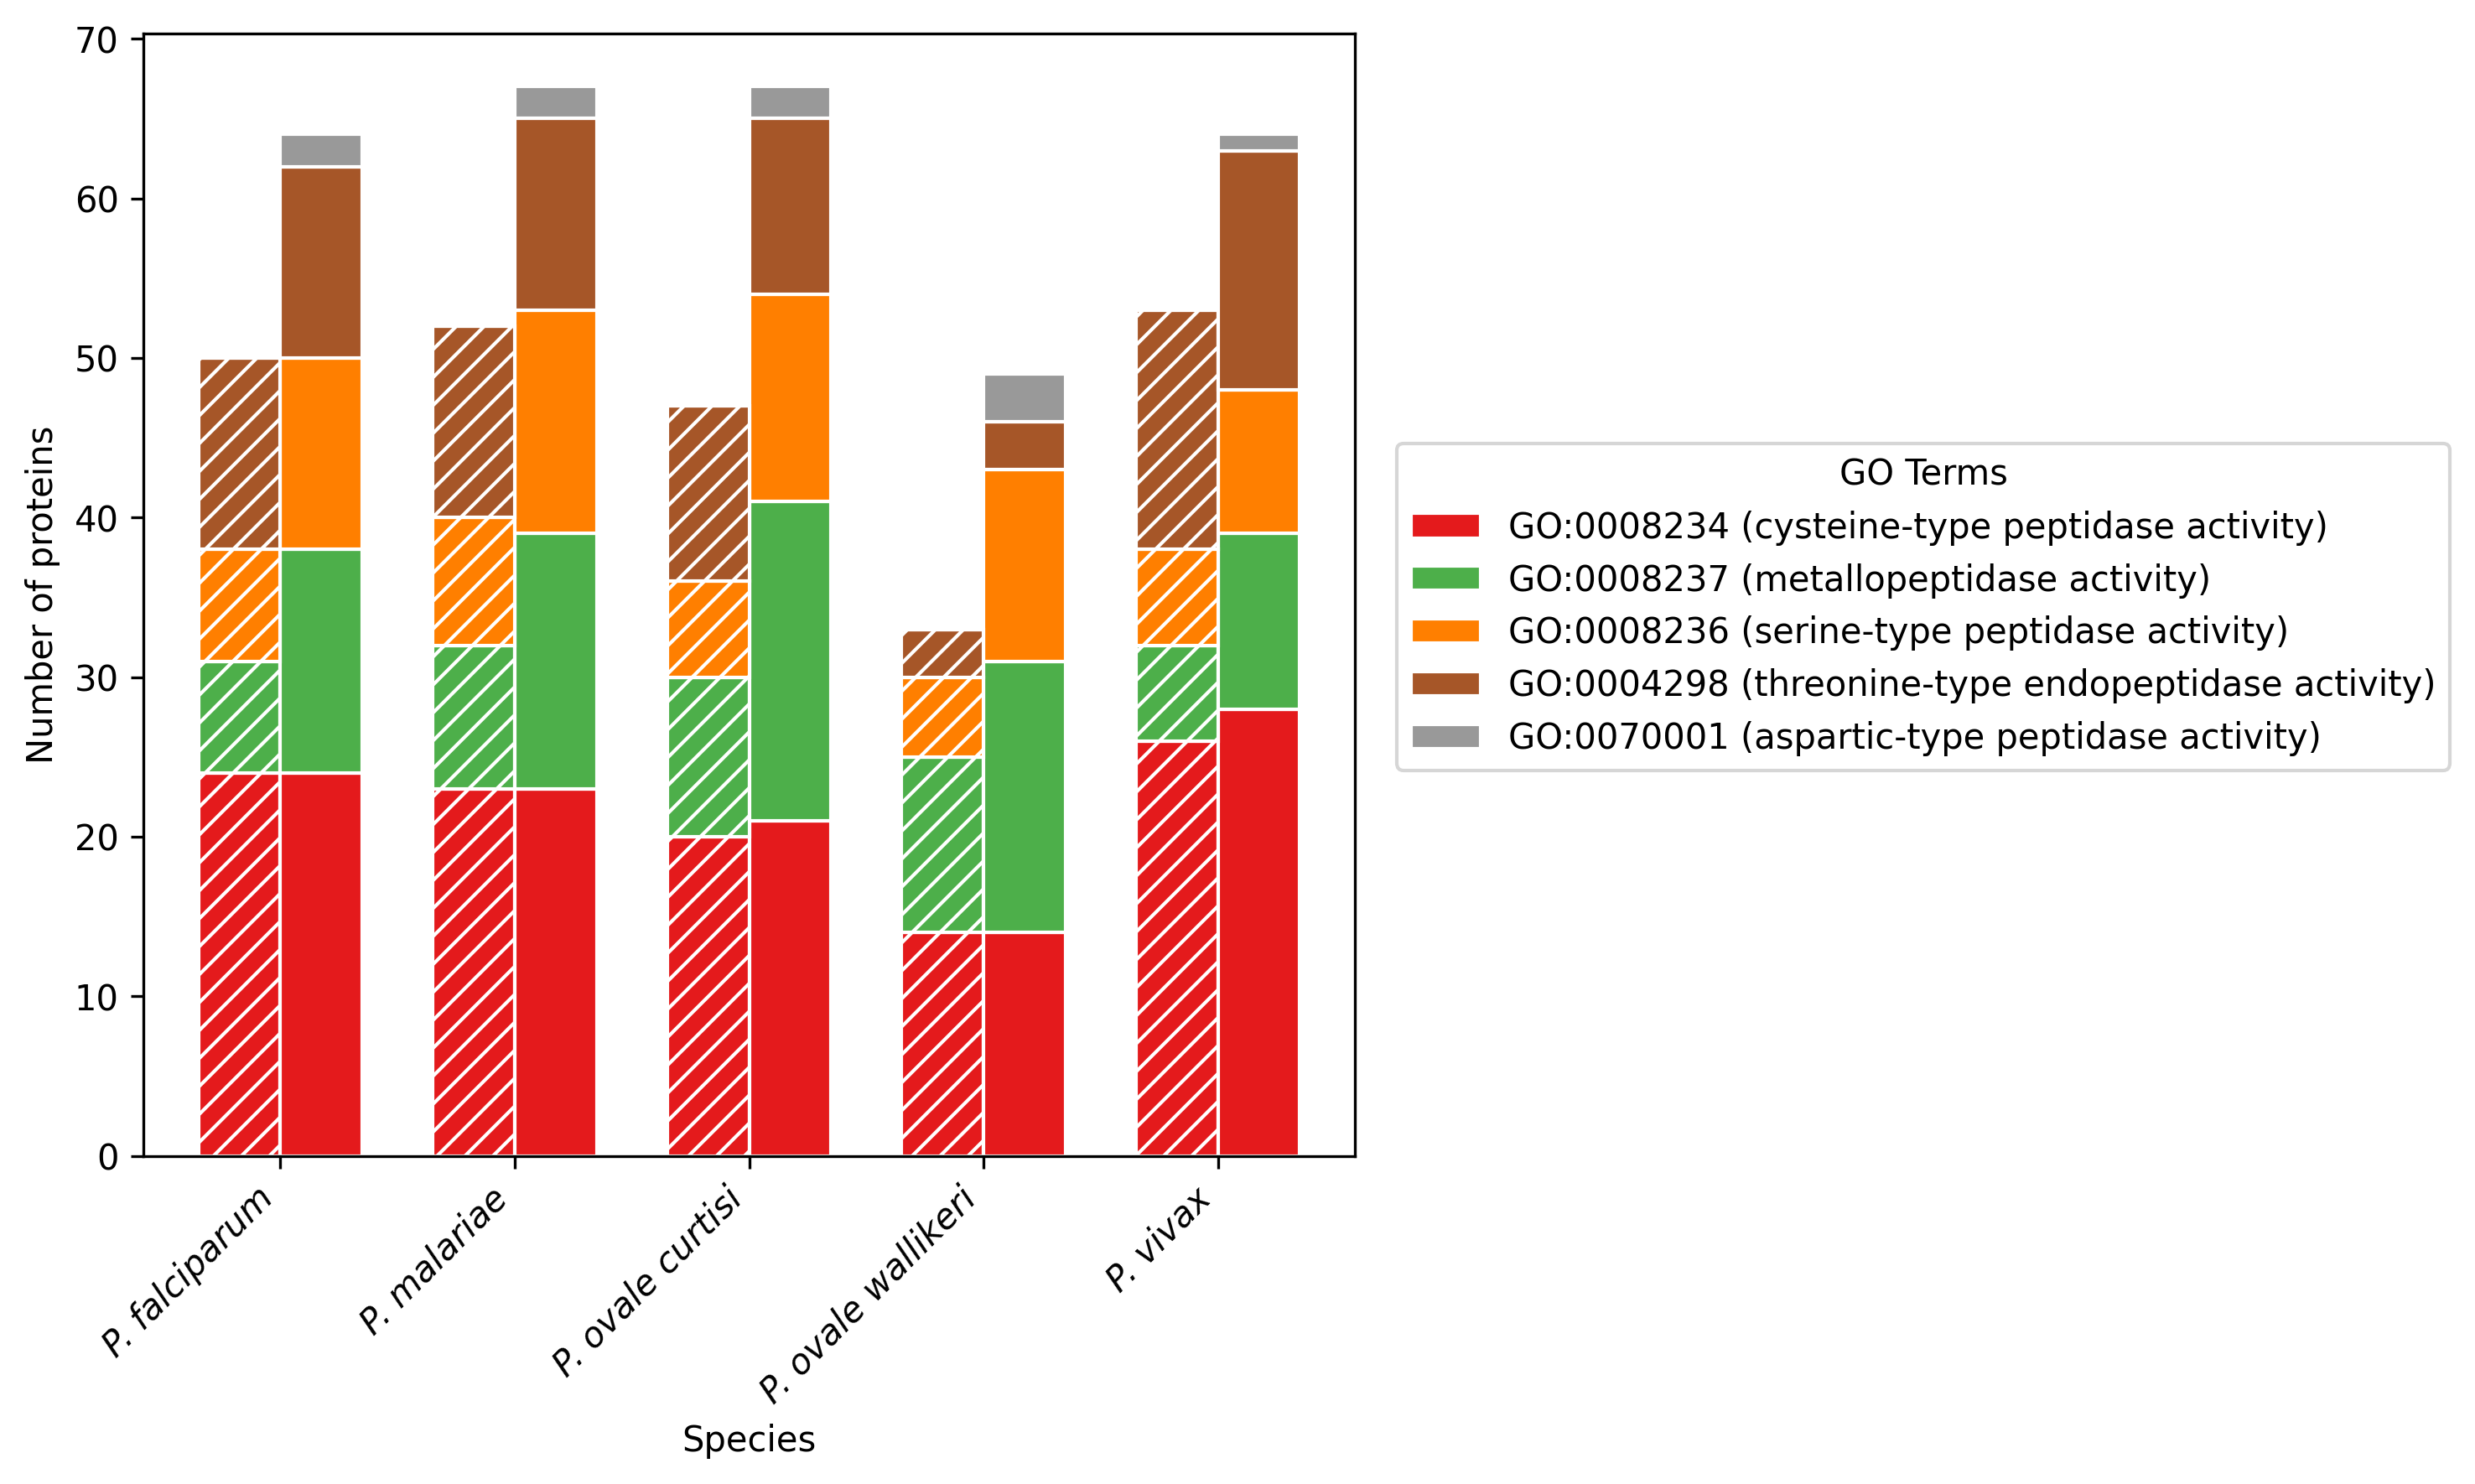

In [24]:
df_cur  = df.pivot(index='Species', columns='GO_ID', values='Curated/IEA').fillna(0)
df_comb = df.pivot(index='Species', columns='GO_ID', values='Curated+PFP').fillna(0)

total_comb = df_comb.sum(axis=0)
go_terms_sorted = total_comb.sort_values(ascending=False).index.tolist()

cmap   = plt.cm.get_cmap('Set1', len(go_terms_sorted))
colors = [cmap(i) for i in range(len(go_terms_sorted))]

species = df_cur.index.map(lambda sp: species_to_name.get(sp, sp))
x       = np.arange(len(species))
bar_w   = 0.35

fig, ax = plt.subplots(figsize=(10,6), dpi=300)

for i, go in enumerate(go_terms_sorted):
    bottom_cur  = df_cur[go_terms_sorted[:i]].sum(axis=1)
    bottom_comb = df_comb[go_terms_sorted[:i]].sum(axis=1)
    
    ax.bar(x - bar_w/2, df_cur[go],
           width=bar_w, bottom=bottom_cur,
           color=colors[i], edgecolor='white',
           hatch='///', label=None)
    
    ax.bar(x + bar_w/2, df_comb[go],
           width=bar_w, bottom=bottom_comb,
           color=colors[i], edgecolor='white',
           label=None)

handles = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='white')
           for i in range(len(go_terms_sorted))]

target_terms = {
    "GO:0008237": "metallopeptidase activity",
    "GO:0008236": "serine-type peptidase activity",
    "GO:0008234": "cysteine-type peptidase activity",
    "GO:0004298": "threonine-type endopeptidase activity",
    "GO:0070001": "aspartic-type peptidase activity"
}


labels  = [f"{go} ({target_terms[go]})" for go in go_terms_sorted]
ax.legend(handles, labels, title="GO Terms",
          bbox_to_anchor=(1.02,0.65), loc='upper left', frameon=True)

ax.set_xticks(x)
ax.set_xticklabels(species, rotation=45, ha='right', fontstyle='italic')
ax.set_xlabel("Species")
ax.set_ylabel("Number of proteins")


plt.tight_layout()
plt.show()


# Transporter 

In [26]:
class_map = {
    # Ion and nucleocytoplasmic transport typically via channels/pores
    'GO:0000041': 'Generic/Not Clearly Defined Transmembrane Transport', # transition metal ion transport (not explicit mechanism)
    'GO:0000054': 'Channel/Pore-based Transmembrane Transport', # ribosomal subunit export from nucleus via nuclear pore
    'GO:0006405': 'Channel/Pore-based Transmembrane Transport', # RNA export from nucleus via nuclear pore
    'GO:0006605': 'Localization/Targeting without Direct Transmembrane Step', # protein targeting (general)
    'GO:0006606': 'Channel/Pore-based Transmembrane Transport', # protein import into nucleus via nuclear pore
    'GO:0006613': 'Channel/Pore-based Transmembrane Transport', # cotranslational protein targeting to membrane (via translocon channel)
    'GO:0006811': 'Channel/Pore-based Transmembrane Transport', # monoatomic ion transport usually via ion channels
    'GO:0006817': 'Secondary Active Transmembrane Transport',   # phosphate ion transport often driven by ion gradients
    'GO:0006839': 'Secondary Active Transmembrane Transport',   # mitochondrial transport often via carrier proteins driven by gradients
    'GO:0006869': 'Generic/Not Clearly Defined Transmembrane Transport', # lipid transport may be non-vesicular or carrier-based but unspecified
    'GO:0006886': 'Vesicle-mediated Transport', # intracellular protein transport often involves vesicles
    'GO:0006892': 'Vesicle-mediated Transport', # post-Golgi vesicle-mediated transport
    'GO:0006913': 'Channel/Pore-based Transmembrane Transport', # nucleocytoplasmic transport via nuclear pore
    'GO:0008104': 'Localization/Targeting without Direct Transmembrane Step', # protein localization
    'GO:0008608': 'Localization/Targeting without Direct Transmembrane Step', # attachment of spindle microtubules to kinetochore is not transmembrane
    'GO:0015031': 'Generic/Not Clearly Defined Transmembrane Transport', # protein transport (too broad)
    'GO:0015698': 'Channel/Pore-based Transmembrane Transport', # inorganic anion transport often through ion channels
    'GO:0015711': 'Secondary Active Transmembrane Transport',   # organic anion transport often via secondary carriers
    'GO:0015748': 'Secondary Active Transmembrane Transport',   # organophosphate ester transport likely by secondary carriers
    'GO:0015850': 'Secondary Active Transmembrane Transport',   # organic hydroxy compound transport, often via secondary carriers
    'GO:0015866': 'Secondary Active Transmembrane Transport',   # ADP transport (e.g., ADP/ATP exchange in mitochondria)
    'GO:0015867': 'Secondary Active Transmembrane Transport',   # ATP transport (ADP/ATP exchange)
    'GO:0015988': 'Primary Active Transmembrane Transport',     # energy coupled proton transport against gradient (e.g., ATP-driven)
    'GO:0016192': 'Vesicle-mediated Transport',
    'GO:0016197': 'Vesicle-mediated Transport', # endosomal transport
    'GO:0016482': 'Localization/Targeting without Direct Transmembrane Step', # cytosolic transport (movement in cytosol)
    'GO:0031503': 'Localization/Targeting without Direct Transmembrane Step', # protein-containing complex localization
    'GO:0032509': 'Vesicle-mediated Transport', # endosome transport via MVB
    'GO:0032940': 'Vesicle-mediated Transport', # secretion by cell (exocytosis)
    'GO:0033365': 'Localization/Targeting without Direct Transmembrane Step', # protein localization to organelle (doesn't necessarily imply crossing membrane)
    'GO:0033750': 'Localization/Targeting without Direct Transmembrane Step', # ribosome localization
    'GO:0034504': 'Channel/Pore-based Transmembrane Transport', # protein localization to nucleus via pore
    'GO:0035459': 'Vesicle-mediated Transport', # vesicle cargo loading
    'GO:0035592': 'Localization/Targeting without Direct Transmembrane Step', # establishment of protein localization to extracellular region (likely secretion pathway)
    'GO:0044743': 'Channel/Pore-based Transmembrane Transport', # protein transmembrane import into intracellular organelle (e.g., via translocon)
    'GO:0045047': 'Channel/Pore-based Transmembrane Transport', # protein targeting to ER via Sec translocon
    'GO:0045184': 'Localization/Targeting without Direct Transmembrane Step',
    'GO:0045324': 'Vesicle-mediated Transport', # late endosome to vacuole
    'GO:0046903': 'Vesicle-mediated Transport', # secretion
    'GO:0046907': 'Vesicle-mediated Transport', # intracellular transport often involves vesicles
    'GO:0048193': 'Vesicle-mediated Transport', # Golgi vesicle transport
    'GO:0050658': 'Channel/Pore-based Transmembrane Transport', # RNA transport (nuclear export)
    'GO:0051028': 'Channel/Pore-based Transmembrane Transport', # mRNA transport (nuclear pore)
    'GO:0051168': 'Channel/Pore-based Transmembrane Transport', # nuclear export via pore
    'GO:0051170': 'Channel/Pore-based Transmembrane Transport', # import into nucleus via pore
    'GO:0051640': 'Localization/Targeting without Direct Transmembrane Step', # organelle localization
    'GO:0051649': 'Localization/Targeting without Direct Transmembrane Step', # establishment of localization in cell
    'GO:0051656': 'Localization/Targeting without Direct Transmembrane Step', # establishment of organelle localization
    'GO:0051668': 'Localization/Targeting without Direct Transmembrane Step', # localization within membrane (lateral movement)
    'GO:0055085': 'Generic/Not Clearly Defined Transmembrane Transport', # too general
    'GO:0070727': 'Localization/Targeting without Direct Transmembrane Step', # cellular macromolecule localization
    'GO:0070972': 'Localization/Targeting without Direct Transmembrane Step', # protein localization to ER (not necessarily crossing)
    'GO:0071705': 'Generic/Not Clearly Defined Transmembrane Transport', # nitrogen compound transport (unspecified mechanism)
    'GO:0071806': 'Channel/Pore-based Transmembrane Transport', # protein transmembrane transport (translocon)
    'GO:0072530': 'Secondary Active Transmembrane Transport',   # purine-containing compound transmembrane transport (likely secondary carriers)
    'GO:0072594': 'Localization/Targeting without Direct Transmembrane Step', # establishment of protein localization to organelle
    'GO:0072655': 'Channel/Pore-based Transmembrane Transport', # establishment of protein localization to mitochondrion via import channels
    'GO:0072657': 'Localization/Targeting without Direct Transmembrane Step', # protein localization to membrane (not necessarily crossing)
    'GO:0090150': 'Localization/Targeting without Direct Transmembrane Step', # establishment of protein localization to membrane
    'GO:0098655': 'Channel/Pore-based Transmembrane Transport', # monoatomic cation transmembrane transport (ion channel)
    'GO:0098657': 'Generic/Not Clearly Defined Transmembrane Transport', # import into cell (could be endocytosis or channel)
    'GO:0098660': 'Channel/Pore-based Transmembrane Transport', # inorganic ion transmembrane transport
    'GO:0098661': 'Channel/Pore-based Transmembrane Transport', # inorganic anion transmembrane transport
    'GO:0098662': 'Channel/Pore-based Transmembrane Transport', # inorganic cation transmembrane transport
    'GO:0098876': 'Vesicle-mediated Transport', # vesicle-mediated transport to PM
    'GO:0099515': 'Cytoskeletal-based Transport',               # actin filament-based transport (not transmembrane)
    'GO:0099518': 'Cytoskeletal-based Transport',               # vesicle cytoskeletal trafficking
    'GO:0140056': 'Localization/Targeting without Direct Transmembrane Step', # organelle localization by membrane tethering
    'GO:0140352': 'Generic/Not Clearly Defined Transmembrane Transport', # export from cell (could be secretion)
    'GO:0170036': 'Channel/Pore-based Transmembrane Transport', # import into mitochondrion via TOM/TIM (channels)
    'GO:1901679': 'Secondary Active Transmembrane Transport',   # nucleotide transmembrane transport often via carriers
    'GO:1905039': 'Secondary Active Transmembrane Transport',   # carboxylic acid transmembrane transport often secondary
    'GO:1990542': 'Secondary Active Transmembrane Transport'    # mitochondrial transmembrane transport (carrier proteins)
}

In [27]:
def analyze_cluster_genes(gene_dicts, cluster_ids, class_map, curated_slots, pfp_slot, species_list):
    """Find genes with cluster terms and classify them ONLY by their cluster GO terms.    """
    
    results = {}
    
    for species in species_list:
        genes = gene_dicts[species]
        
        curated_genes_by_category = defaultdict(set)
        combined_genes_by_category = defaultdict(set)
        
        for gene_id, annotations in genes.items():
            
            curated_cluster_terms = set()
            for slot in curated_slots:
                for go_term in annotations.get(slot, []):
                    if go_term in cluster_ids:
                        curated_cluster_terms.add(go_term)
            
            pfp_cluster_terms = set()
            for fdr_level, predictions in annotations.get(pfp_slot, {}).items():
                for prediction in predictions:
                    if isinstance(prediction, tuple):
                        go_term = prediction[0]  
                    else:
                        go_term = prediction  
                    
                    if go_term in cluster_ids:
                        pfp_cluster_terms.add(go_term)
            
            
            if curated_cluster_terms:
                for go_term in curated_cluster_terms:
                    category = class_map.get(go_term, 'Unclassified')
                    curated_genes_by_category[category].add(gene_id)
            
            all_cluster_terms = curated_cluster_terms | pfp_cluster_terms
            if all_cluster_terms:
                for go_term in all_cluster_terms:
                    category = class_map.get(go_term, 'Unclassified')
                    combined_genes_by_category[category].add(gene_id)
        
        results[species] = {
            'curated': {cat: list(genes) for cat, genes in curated_genes_by_category.items()},
            'combined': {cat: list(genes) for cat, genes in combined_genes_by_category.items()}
        }
    
    return results

cluster3_ids = set(bp_clusters.loc[bp_clusters['ClusterID']==3, 'GO_ID'])
curated_slots = ['GO Process', 'GO IEA Process']
pfp_slot = 'PFP BP'
human_malaria = [
    'PlasmoDB-68_Pfalciparum3D7',
    'PlasmoDB-68_PvivaxSal1',
    'PlasmoDB-68_PmalariaeUG01',
    'PlasmoDB-68_PovalecurtisiGH01',
    'PlasmoDB-68_PovalewallikeriPowCR01'
]

results = analyze_cluster_genes(
    gene_dicts=gene_dicts,
    cluster_ids=cluster3_ids,
    class_map=class_map,
    curated_slots=curated_slots,
    pfp_slot=pfp_slot,
    species_list=human_malaria
)

for species in human_malaria:
    print(f"\n{species_to_name.get(species, species)}:")
    
    for mode in ['curated', 'combined']:
        print(f"  {mode.capitalize()}:")
        total_genes = set()
        for category, gene_list in results[species][mode].items():
            total_genes.update(gene_list)
            print(f"    {category}: {len(gene_list)} proteins")
        print(f"    Total unique proteins: {len(total_genes)}")


P. falciparum:
  Curated:
    Unclassified: 320 proteins
    Generic/Not Clearly Defined Transmembrane Transport: 93 proteins
    Vesicle-mediated Transport: 132 proteins
    Localization/Targeting without Direct Transmembrane Step: 5 proteins
    Channel/Pore-based Transmembrane Transport: 29 proteins
    Secondary Active Transmembrane Transport: 3 proteins
    Total unique proteins: 423
  Combined:
    Unclassified: 466 proteins
    Generic/Not Clearly Defined Transmembrane Transport: 180 proteins
    Vesicle-mediated Transport: 160 proteins
    Secondary Active Transmembrane Transport: 14 proteins
    Localization/Targeting without Direct Transmembrane Step: 148 proteins
    Channel/Pore-based Transmembrane Transport: 55 proteins
    Cytoskeletal-based Transport: 2 proteins
    Total unique proteins: 589

P. vivax:
  Curated:
    Unclassified: 204 proteins
    Vesicle-mediated Transport: 107 proteins
    Generic/Not Clearly Defined Transmembrane Transport: 87 proteins
    Channel/P

In [28]:
def results_to_pivot_dataframe(results, species_to_name):
    """
    Convert results to a pivot table format with categories as columns.
    """
    
    data = []
    
    for species_id, modes in results.items():
        species_name = species_to_name.get(species_id, species_id)
        
        for mode, categories in modes.items():
            row = {
                'Species': species_name,
                'Species_ID': species_id,
                'Mode': mode.capitalize()
            }
            
            for category, gene_list in categories.items():
                row[category] = len(gene_list)
            
            all_genes = set()
            for gene_list in categories.values():
                all_genes.update(gene_list)
            row['Total_Unique'] = len(all_genes)
            
            data.append(row)
    
    return pd.DataFrame(data).fillna(0)

df_pivot = results_to_pivot_dataframe(results, species_to_name)
print(df_pivot)
df_pivot.to_csv('transport_analysis_pivot.csv', index=False)

              Species                          Species_ID      Mode  \
0       P. falciparum          PlasmoDB-68_Pfalciparum3D7   Curated   
1       P. falciparum          PlasmoDB-68_Pfalciparum3D7  Combined   
2            P. vivax              PlasmoDB-68_PvivaxSal1   Curated   
3            P. vivax              PlasmoDB-68_PvivaxSal1  Combined   
4         P. malariae           PlasmoDB-68_PmalariaeUG01   Curated   
5         P. malariae           PlasmoDB-68_PmalariaeUG01  Combined   
6    P. ovale curtisi       PlasmoDB-68_PovalecurtisiGH01   Curated   
7    P. ovale curtisi       PlasmoDB-68_PovalecurtisiGH01  Combined   
8  P. ovale wallikeri  PlasmoDB-68_PovalewallikeriPowCR01   Curated   
9  P. ovale wallikeri  PlasmoDB-68_PovalewallikeriPowCR01  Combined   

   Unclassified  Generic/Not Clearly Defined Transmembrane Transport  \
0           320                                                 93     
1           466                                                180     
2 

In [29]:
fc_df = (
    df_pivot.pivot(index="Species", columns="Mode", values="Total_Unique")
    .assign(FoldChange=lambda x: x["Combined"] / x["Curated"])
    .reset_index()
)

fc_df_sorted = fc_df.sort_values("FoldChange", ascending=False)
fc_df_sorted

Mode             Species  Combined  Curated  FoldChange
3     P. ovale wallikeri       485      212    2.287736
2       P. ovale curtisi       496      234    2.119658
1            P. malariae       476      244    1.950820
4               P. vivax       540      318    1.698113
0          P. falciparum       589      423    1.392435

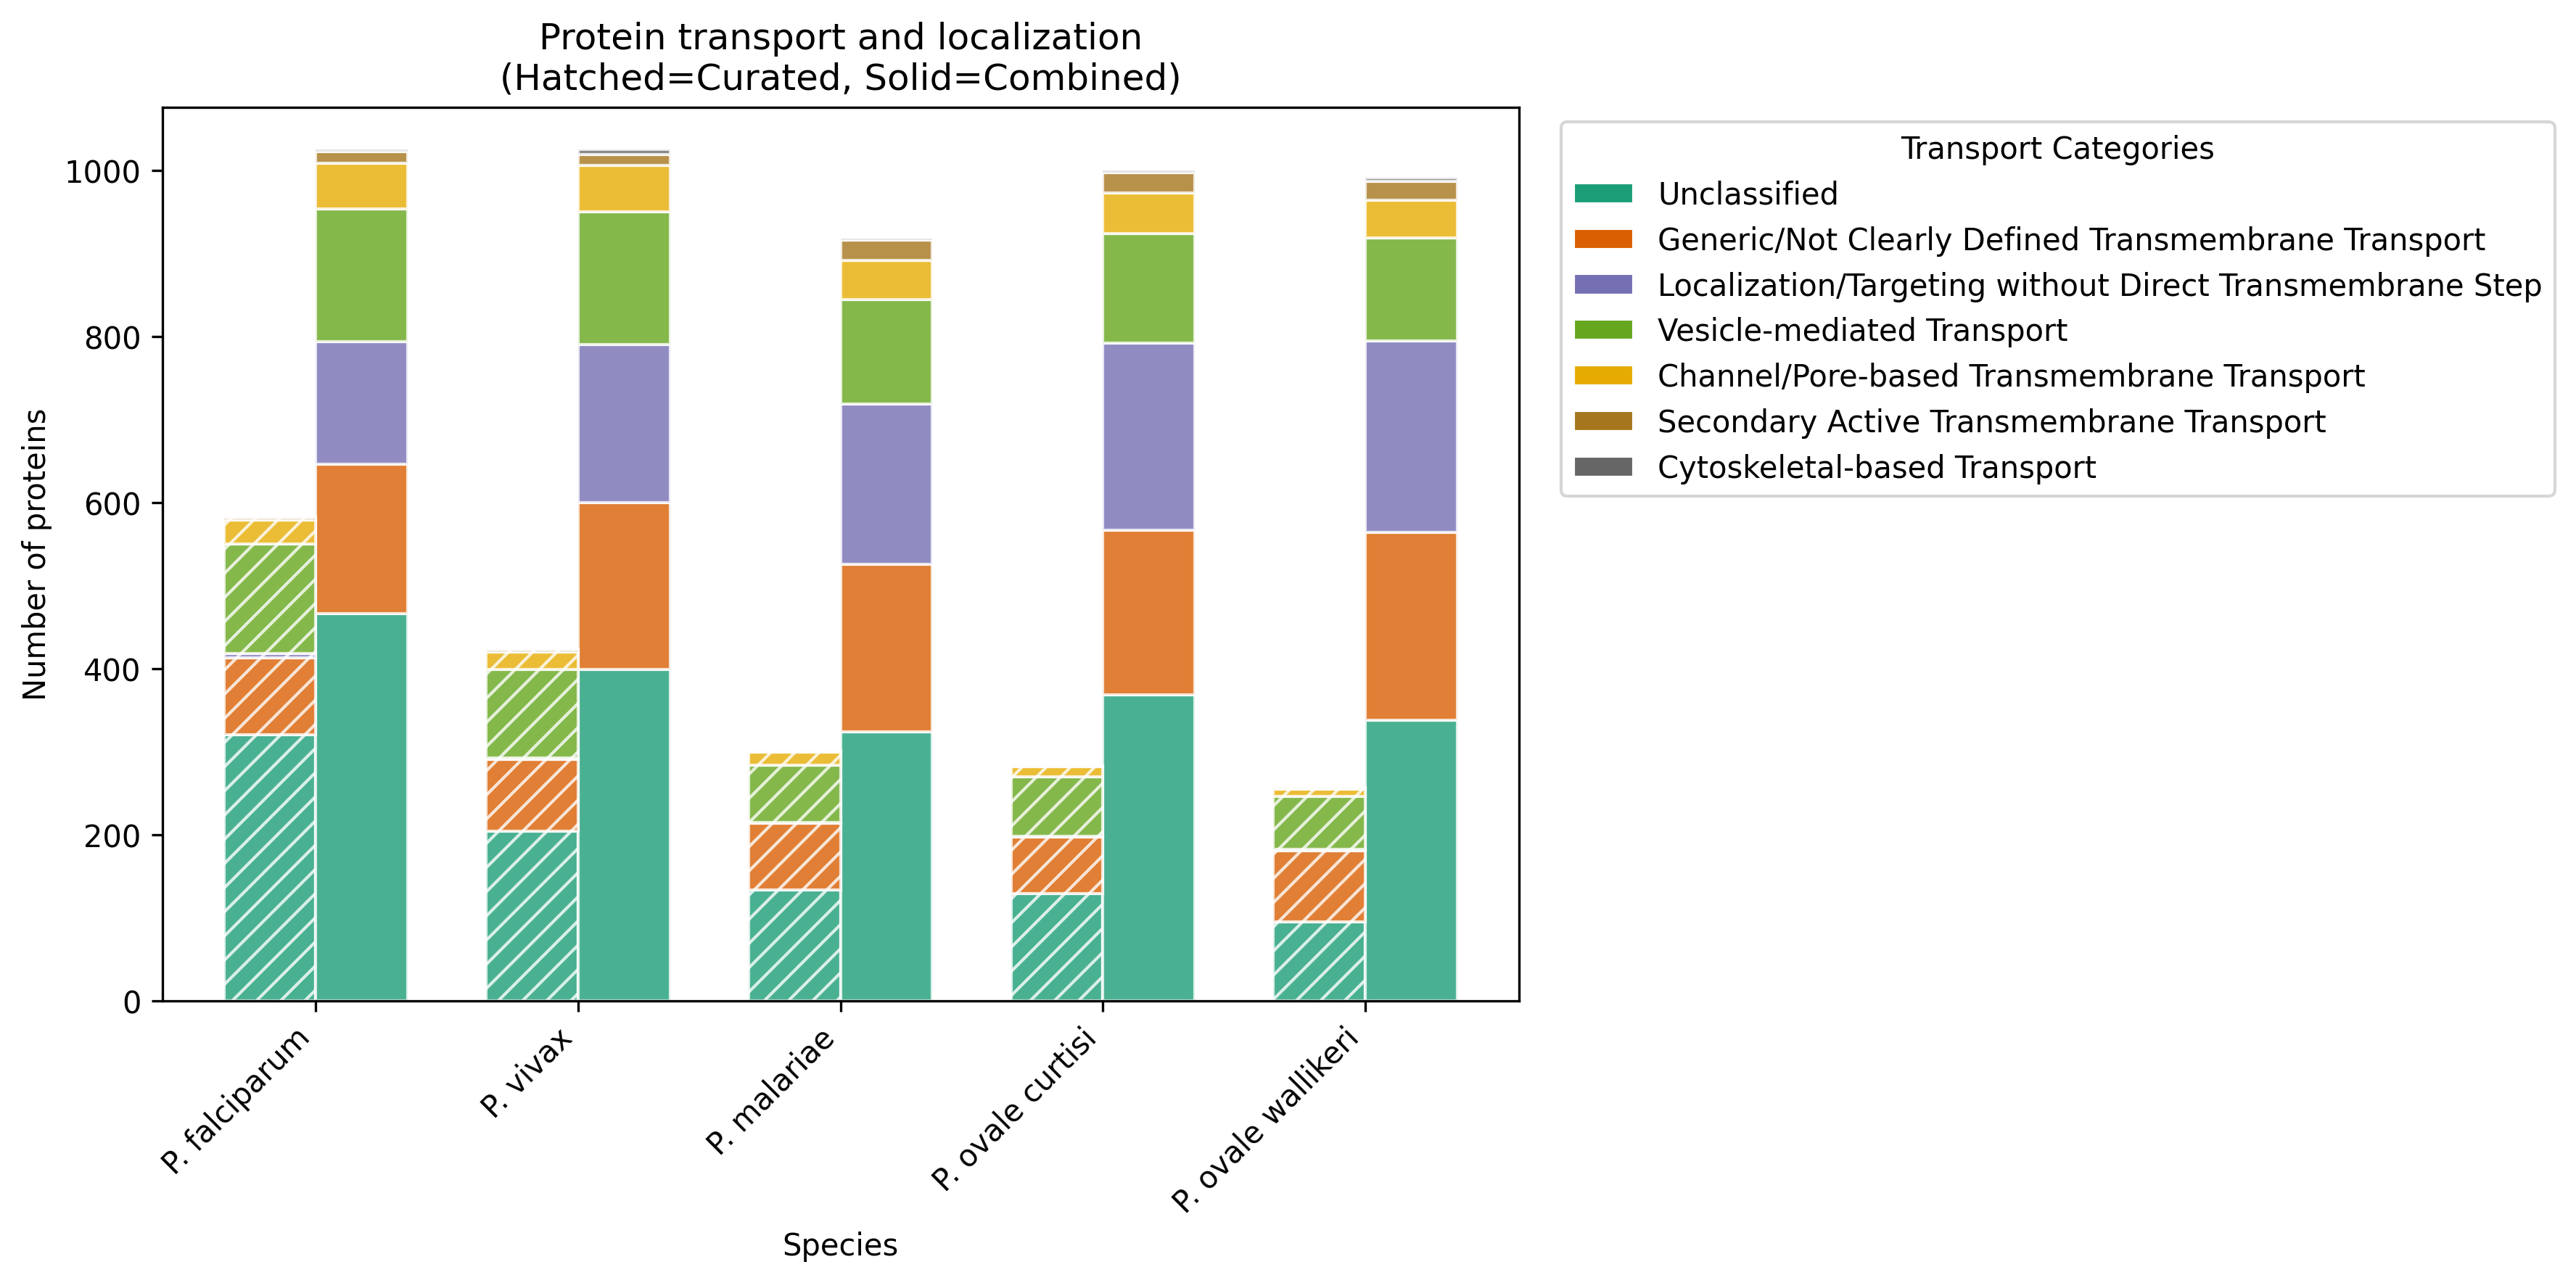

In [30]:
def plot_cluster_results_simple(results, species_to_name):
    
    counts_cur = defaultdict(lambda: defaultdict(int))
    counts_comb = defaultdict(lambda: defaultdict(int))
    
    for species_id, modes in results.items():
        for category, gene_list in modes['curated'].items():
            counts_cur[species_id][category] = len(gene_list)
        for category, gene_list in modes['combined'].items():
            counts_comb[species_id][category] = len(gene_list)
    
    df_cur = pd.DataFrame(counts_cur).T.fillna(0).astype(int)
    df_comb = pd.DataFrame(counts_comb).T.fillna(0).astype(int)
    
    all_cats_sorted = df_comb.sum(axis=0).sort_values(ascending=False).index.tolist()
    df_cur = df_cur.reindex(columns=all_cats_sorted, fill_value=0)
    df_comb = df_comb.reindex(columns=all_cats_sorted, fill_value=0)
    
    species = [species_to_name.get(sp, sp) for sp in df_cur.index]
    x = np.arange(len(species))
    bar_w = 0.35
    
    cmap = plt.cm.get_cmap('Dark2', len(all_cats_sorted))
    colors = [cmap(i) for i in range(len(all_cats_sorted))]
    
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
    
    for i, cat in enumerate(all_cats_sorted):
        bottom_cur = df_cur[all_cats_sorted[:i]].sum(axis=1) if i > 0 else 0
        bottom_comb = df_comb[all_cats_sorted[:i]].sum(axis=1) if i > 0 else 0
        
        ax.bar(x - bar_w/2, df_cur[cat], width=bar_w, bottom=bottom_cur,
               color=colors[i], edgecolor='white', hatch='///', alpha=0.8)
        ax.bar(x + bar_w/2, df_comb[cat], width=bar_w, bottom=bottom_comb,
               color=colors[i], edgecolor='white', alpha=0.8)
    
    handles = [plt.Rectangle((0,0), 1, 1, facecolor=colors[i], edgecolor='white')
               for i in range(len(all_cats_sorted))]
    ax.legend(handles, all_cats_sorted, title="Transport Categories",
              bbox_to_anchor=(1.02, 1), loc='upper left')
    
    ax.set_xticks(x)
    ax.set_xticklabels(species, rotation=45, ha='right')
    ax.set_xlabel("Species")
    ax.set_ylabel("Number of proteins")
    ax.set_title("Protein transport and localization\n(Hatched=Curated, Solid=Combined)")
    
    plt.tight_layout()
    plt.show()

plot_cluster_results_simple(results, species_to_name)

Combined plots 

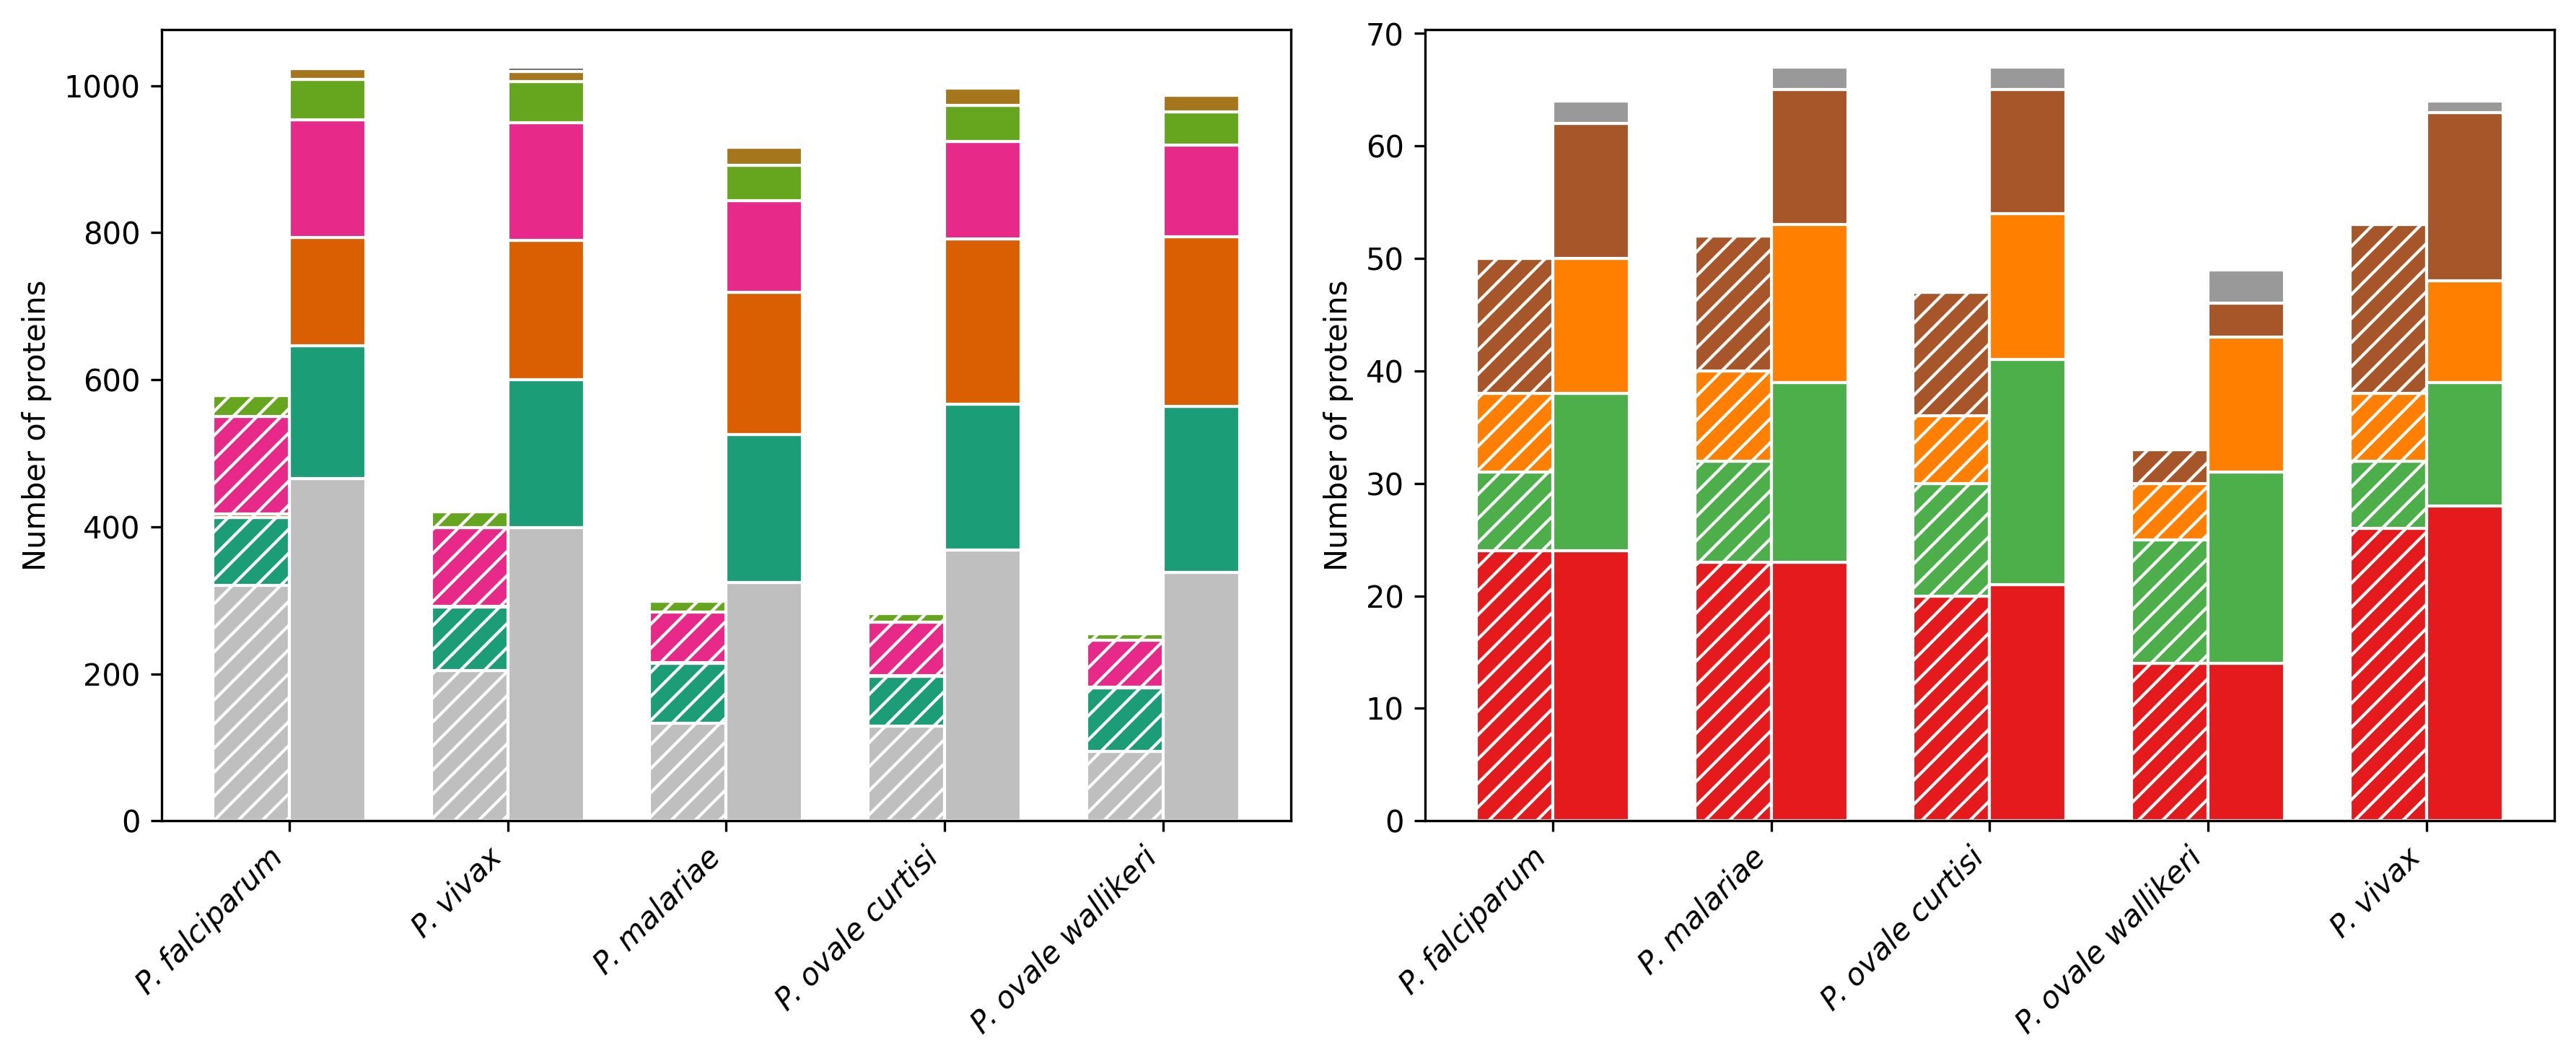

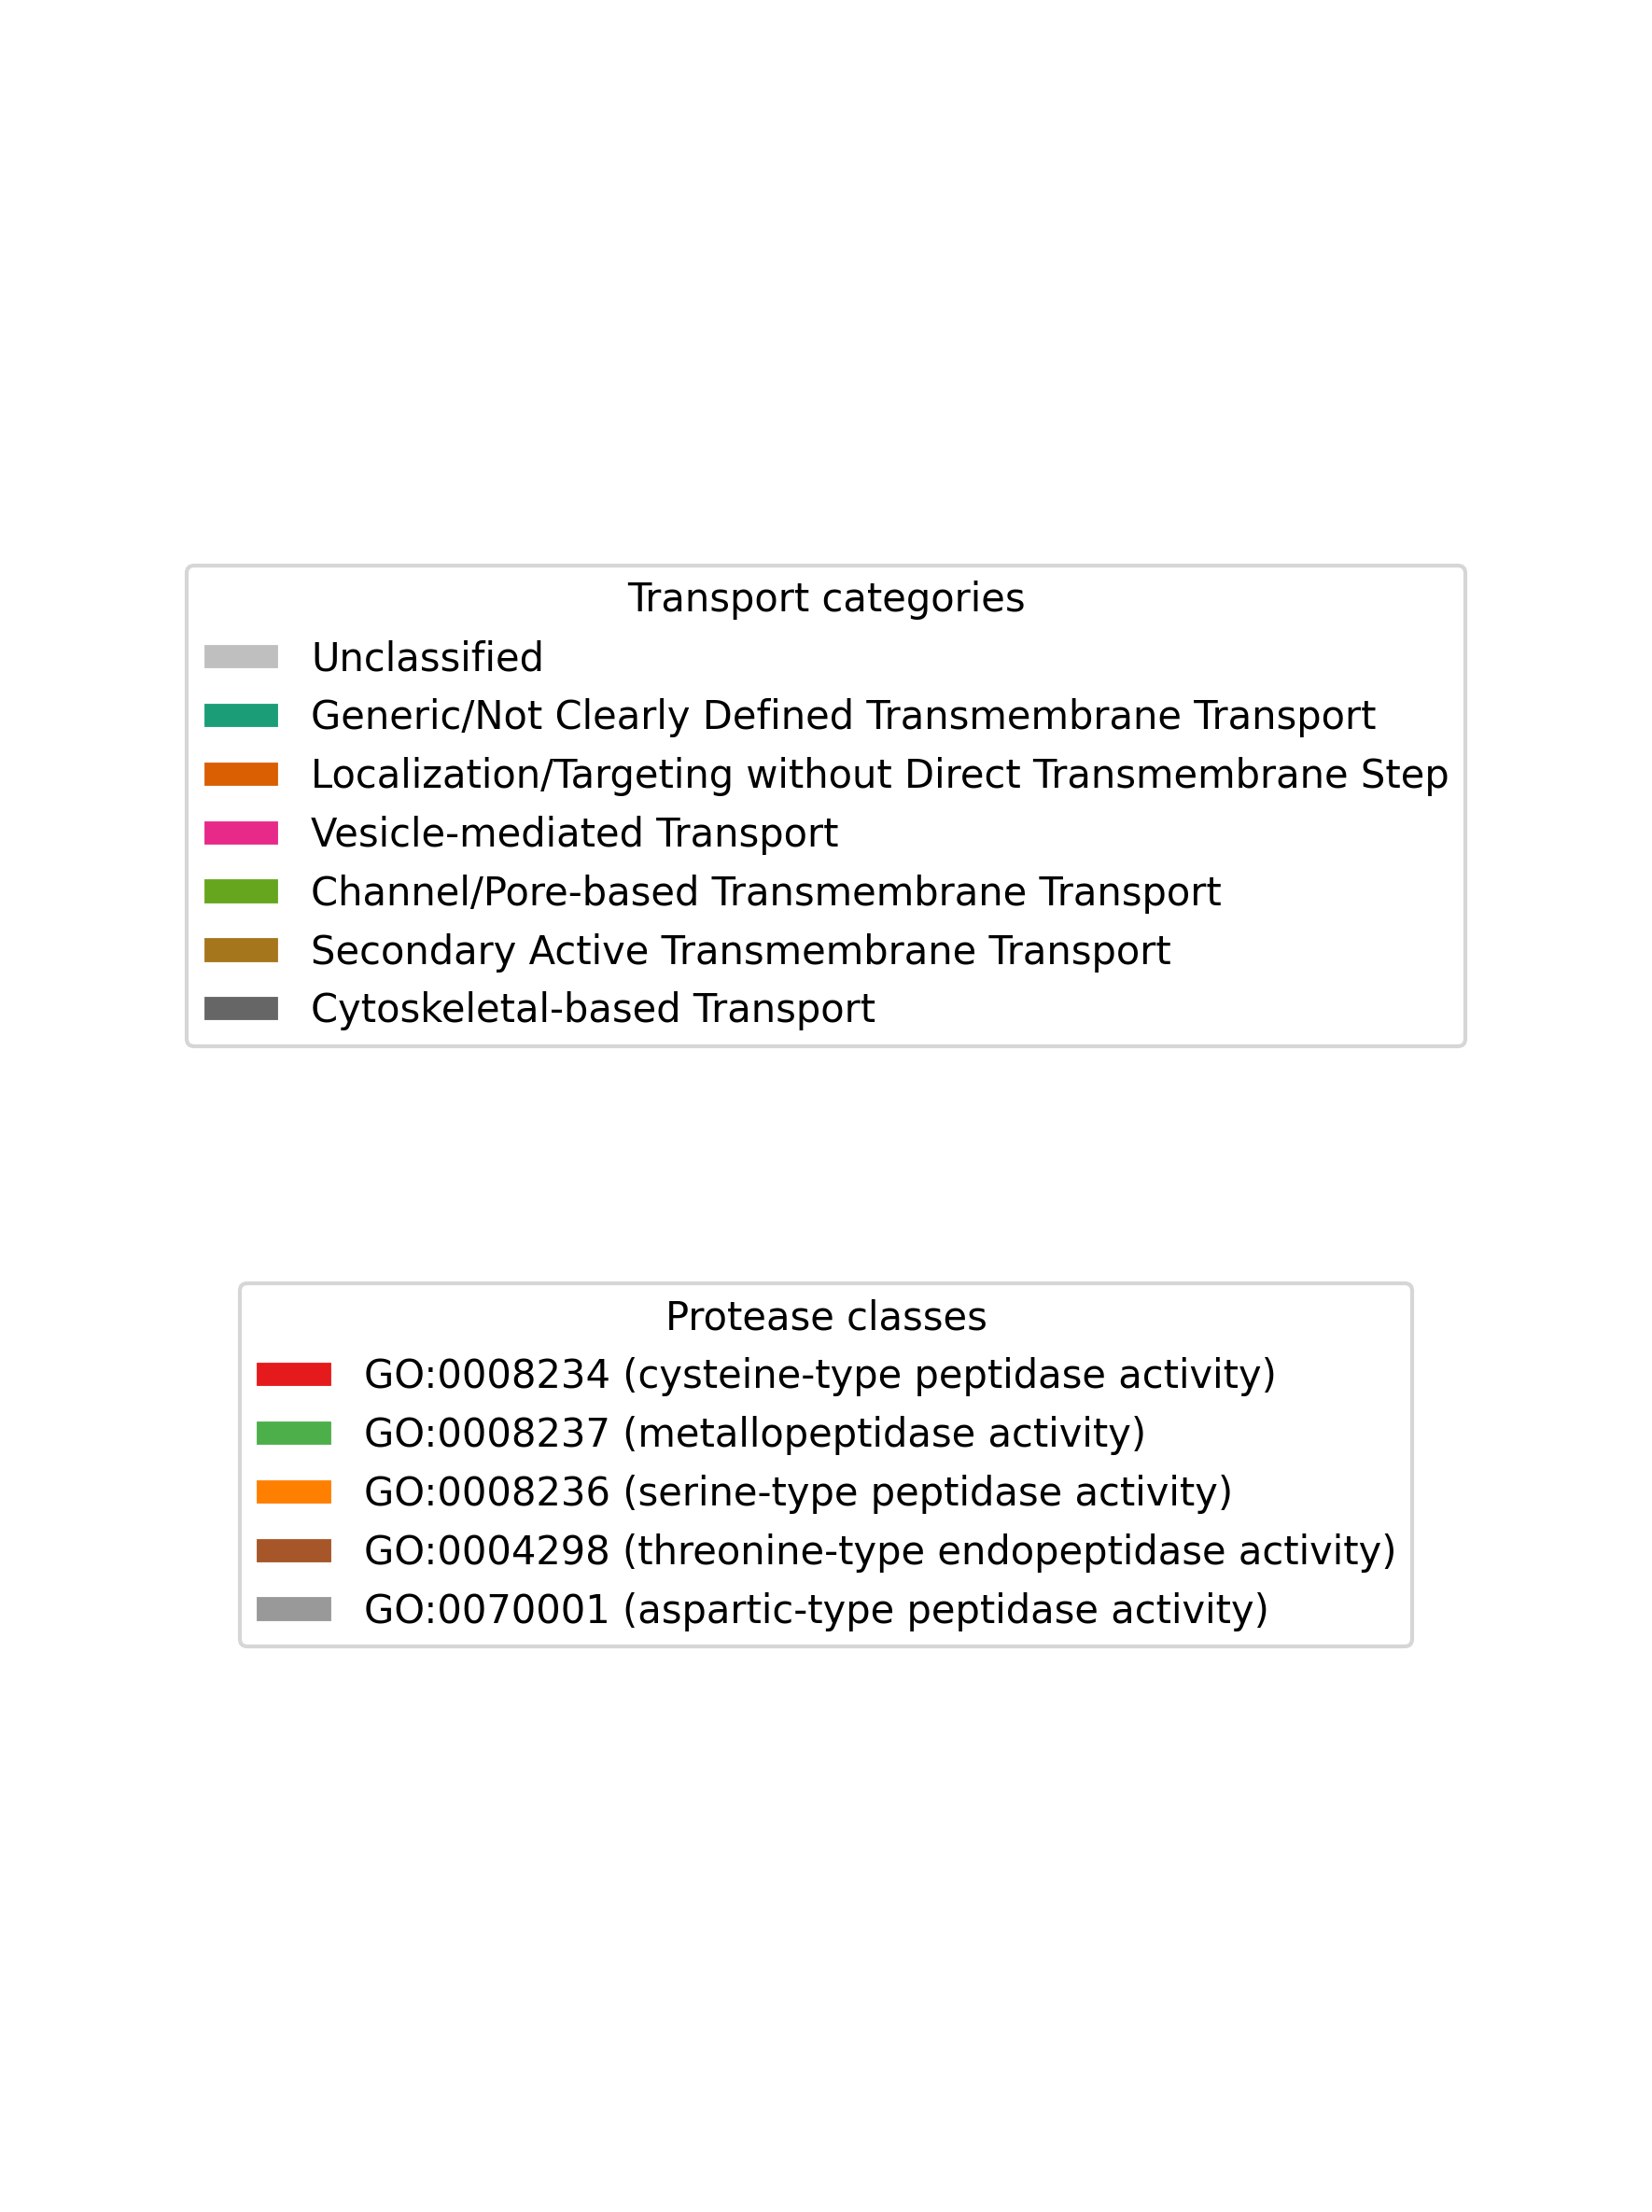

In [ ]:
mpl.rc('figure', figsize=(12, 5), dpi=300, autolayout=True)

def results_to_dataframes(results):
    """Convert analyze_cluster_genes results to DataFrames matching old format"""
    counts_cur = defaultdict(lambda: defaultdict(int))
    counts_comb = defaultdict(lambda: defaultdict(int))
    
    for species_id, modes in results.items():
        for category, gene_list in modes['curated'].items():
            counts_cur[species_id][category] = len(gene_list)
        
        for category, gene_list in modes['combined'].items():
            counts_comb[species_id][category] = len(gene_list)
    
    df_cur_trans = pd.DataFrame(counts_cur).T.fillna(0).astype(int)
    df_comb_trans = pd.DataFrame(counts_comb).T.fillna(0).astype(int)
    
    trans_cats = df_comb_trans.sum(axis=0).sort_values(ascending=False).index.tolist()
    
    if 'Unclassified' in trans_cats:
        trans_cats = ['Unclassified'] + [c for c in trans_cats if c != 'Unclassified']
    
    df_cur_trans = df_cur_trans.reindex(columns=trans_cats, fill_value=0)
    df_comb_trans = df_comb_trans.reindex(columns=trans_cats, fill_value=0)
    
    return df_cur_trans, df_comb_trans, trans_cats

df_cur_trans, df_comb_trans, trans_cats = results_to_dataframes(results)

df_cur_go = df.pivot(index='Species', columns='GO_ID', values='Curated/IEA').fillna(0)
df_comb_go = df.pivot(index='Species', columns='GO_ID', values='Curated+PFP').fillna(0)
go_terms = df_comb_go.sum(axis=0).sort_values(ascending=False).index.tolist()

def plot_grouped_stacked(ax, df_cur, df_comb, labels, cmap_name, base_label='Unclassified'):
    
    if 'PlasmoDB' in str(df_cur.index[0]):  
        species = [species_to_name.get(sp, sp) for sp in df_cur.index]
    else:  
        species = df_cur.index.tolist()
    
    x, w = np.arange(len(species)), 0.35

    cmap = plt.cm.get_cmap(cmap_name, max(len(labels) - (base_label in labels), 1))
    color_for = {}
    k = 0
    for lbl in labels:
        if lbl == base_label:
            color_for[lbl] = (0.75, 0.75, 0.75, 1.0)  
        else:
            color_for[lbl] = cmap(k); k += 1

    for i, lbl in enumerate(labels):
        bottom_cur = df_cur[labels[:i]].sum(axis=1) if i > 0 else 0
        bottom_comb = df_comb[labels[:i]].sum(axis=1) if i > 0 else 0

        ax.bar(x - w/2, df_cur[lbl], bottom=bottom_cur, width=w,
               color=color_for[lbl], edgecolor='white', hatch='///')

        ax.bar(x + w/2, df_comb[lbl], bottom=bottom_comb, width=w,
               color=color_for[lbl], edgecolor='white', label=lbl)

    ax.set_xticks(x)
    ax.set_xticklabels(species, rotation=45, ha='right', fontstyle='italic')
    ax.set_ylabel("Number of proteins")

fig, (ax1, ax2) = plt.subplots(1, 2)

plot_grouped_stacked(
    ax1, df_cur_trans, df_comb_trans,
    labels=trans_cats, cmap_name='Dark2'
)
# ax1.set_title("Protein transport and localization")

plot_grouped_stacked(
    ax2, df_cur_go, df_comb_go,
    labels=go_terms, cmap_name='Set1'
)
# ax2.set_title("Proteases across the Plasmodium genus")

plt.tight_layout()
plt.show()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

fig_leg = plt.figure(figsize=(6, 8), dpi=300)

legend1 = fig_leg.legend(
    handles1, labels1,
    title="Transport categories",
    loc='upper center',
    frameon=True,
    bbox_to_anchor=(0.5, 0.75)
)
target_terms = {
    "GO:0008237": "metallopeptidase activity",
    "GO:0008236": "serine-type peptidase activity", 
    "GO:0008234": "cysteine-type peptidase activity",
    "GO:0004298": "threonine-type endopeptidase activity",
    "GO:0070001": "aspartic-type peptidase activity"
}

legend2_labels = [f"{go} ({target_terms[go]})" for go in labels2]
legend2 = fig_leg.legend(
    handles2, legend2_labels,
    title="Protease classes",
    loc='lower center',
    frameon=True,
    bbox_to_anchor=(0.5, 0.25)
)

fig_leg.gca().axis('off')
plt.show()